In [1]:
# Time Series Segmentation of OHIOT1DM

#Libraries
import os
import pickle
import pandas as pd
import stumpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.patches import Rectangle
import xml.etree.ElementTree as ET
from datetime import datetime
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from AlmaIndicator import ALMAIndicator
from fcmeans import FCM
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering
from tslearn.clustering import TimeSeriesKMeans
from pyclustertend import hopkins
from sklearn.preprocessing import scale
from pyclustertend import ivat
from random import randint
import seaborn as sns

data_folder = "OhioT1DM-full-access\OhioT1DM-training"
os.chdir(data_folder)

c:\Users\metin\AppData\Local\Programs\Python\Python37\lib\site-packages\tslearn\clustering\kmeans.py:17: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  "Scikit-learn <0.24 will be deprecated in a "


In [105]:
# Helper functions

def convert_time(date_string): # takes '30-11-2021 17:06:00' format date and returns seconds since epoch (timestamp)
    first_split = date_string.split()
    day, month, year, = first_split[0].split("-")
    hour, minute, second = first_split[1].split(":")
    seconds_since = int(second) + int(minute)*60 + int(hour)*60*60 + int(day)*60*60*24 + int(month)*60*60*24*30 + int(year)*60*60*24*30*12
    return seconds_since

def round_time(mark, glucose_dict):  # takes timestamps of any log and glucose log, rounds it to closest timestamp of blood glucose measurement *** can be more efficient ***
    diffs = []
    for key in glucose_dict:
        diffs.append((abs(key-mark), key))
    return sorted(diffs)[0][1]

def prepare_data(filename): # takes data path and returns pandas dataframe 

    #Load file
    tree = ET.parse(filename)
    root = tree.getroot()
    print(root.tag)
    print(root.attrib)
    for child in root:
        print(child.tag, child.attrib, len(child))
    
    #Obtain features and their timestamps
    glucose_dict = dict() 
    for elem in root[0]:
        time = convert_time(elem.attrib["ts"])
        val = elem.attrib["value"]
        glucose_dict[time] = val

    meal_dict = {key : 0 for key in glucose_dict.keys()}
    for elem in root[5]:
        meal_dict[round_time(convert_time(elem.attrib['ts']), glucose_dict)] = float(elem.attrib['carbs'])

    finger_dict = {key : 0 for key in glucose_dict.keys()}
    for elem in root[1]:
        finger_dict[round_time(convert_time(elem.attrib['ts']), glucose_dict)] = float(elem.attrib['value'])

    basal_dict = {key : 0 for key in glucose_dict.keys()}
    for elem in root[2]:
        basal_dict[round_time(convert_time(elem.attrib['ts']), glucose_dict)] = float(elem.attrib['value'])

    temp_dict = {key : 0 for key in glucose_dict.keys()}
    for elem in root[3]:
        temp_dict[round_time(convert_time(elem.attrib['ts_begin']), glucose_dict)] = float(elem.attrib['value'])

    bolus_dict = {key : 0 for key in glucose_dict.keys()}
    for elem in root[4]:
        bolus_dict[round_time(convert_time(elem.attrib['ts_begin']), glucose_dict)] = float(elem.attrib['dose'])

    sleep_dict = {key : 0 for key in glucose_dict.keys()}
    for elem in root[6]:
        sleep_dict[round_time(convert_time(elem.attrib['ts_end']), glucose_dict)] = 1 # end and beginning labels are mixed (sleep state is actually awake state)

    wake_dict = {key : 0 for key in glucose_dict.keys()}
    for elem in root[6]:
        wake_dict[round_time(convert_time(elem.attrib['ts_begin']), glucose_dict)] = float(elem.attrib['quality'])

    hypo_dict = {key : 0 for key in glucose_dict.keys()}
    for elem in root[9]:
        hypo_dict[round_time(convert_time(elem.attrib['ts']), glucose_dict)] = 1

    exercise_dict = {key : 0 for key in glucose_dict.keys()}
    for elem in root[11]:
        exercise_dict[round_time(convert_time(elem.attrib['ts']), glucose_dict)] = int(elem.attrib['intensity'])*int(elem.attrib['duration'])

    heart_dict = {key : 0 for key in glucose_dict.keys()}
    for elem in root[12]:
        heart_dict[round_time(convert_time(elem.attrib['ts']), glucose_dict)] = float(elem.attrib['value'])

    df = pd.DataFrame({'Timestamp': [keys for keys in glucose_dict.keys()],
                    'Glucose': np.array([values for values in glucose_dict.values()]).astype(float),
                    'Carbs': [values for values in meal_dict.values()],
                    'Finger_stick' : [values for values in finger_dict.values()],
                    'Basal' : [values for values in basal_dict.values()],
                    'Temporary' : [values for values in temp_dict.values()],
                    'Bolus' : [values for values in bolus_dict.values()],
                    'Sleep' : [values for values in sleep_dict.values()],
                    'Wake' : [values for values in wake_dict.values()],
                    'Hypo_event' : [values for values in hypo_dict.values()],
                    'Exercise' : [values for values in exercise_dict.values()],
                    'Heart_rate' : [values for values in heart_dict.values()],})
    
    return df

# Processing - Derivative & ALMA filter

def process_data(df):
    # smoothing and taking derivative
    timesteps = {} # for storing 5 min interval index of events
    for key in df.columns: 
        print(key)
        collector = {}
        for i in range(len(df[key])):
            if df[key][i] > 0 : collector[i] = df[key][i]
        timesteps[key] = collector
    
    first_derivative = []
    for i in range(len(timesteps['Glucose'].values())):
        if i > 0: 
            rate = (timesteps['Glucose'][i] - timesteps['Glucose'][i-1])/5
        else: rate = 0
        first_derivative.append(rate)

    second_derivative = []
    for i in range(len(first_derivative)):
        if i > 0: 
            rate = (first_derivative[i] - first_derivative[i-5])/5
        else: rate = 0
        second_derivative.append(rate)

    df['Glucose_first_derivative'] = first_derivative

    alma_indicator = ALMAIndicator(close=df['Glucose'])
    df['Glucose_alma'] = alma_indicator.alma()
    df['Glucose_derivative_alma'] = ALMAIndicator(close=df['Glucose_first_derivative']).alma()
    return df, timesteps

def reduce_mp(mp, similarity_cutoff): # takes matrix profile, sorts it and removes least similar pairs based on parameter given (0.2 keeps 20% most similar ones)
    sorted_mp = pd.DataFrame(sorted([(elem[0], elem[2], elem[3]) for elem in mp], reverse=False))
    sorted_mp.rename(columns={sorted_mp.columns[0]: 'Distance', sorted_mp.columns[1]: 'Seq 1 timestamp', sorted_mp.columns[2]: 'Seq 2 timestamp'},inplace=True)
    return sorted_mp[:round(similarity_cutoff*len(mp))]

def make_mp_unique(reduced_mp, neighbour_cutoff ): # takes reduced matrix profile and removes greatly overlapping pairs (neighbours)
    index_of_duplicates = []
    for i in range(len(reduced_mp)):
        if i != 0:
            for j in range(i):
                if abs(reduced_mp['Seq 1 timestamp'][i] - reduced_mp['Seq 1 timestamp'][j]) < 16:
                    index_of_duplicates.append(i)
                    break
    return reduced_mp.drop(index_of_duplicates)

def cluster_on_gradient1(unique_mp, rate_threshold): # takes unique sequence pairs, clusters them based on gradient, rate parameter signifies threshold for separation
    # a value of 1 indicates that for a motif to be considered ascending, the glucose levels must be rising on average at least by 1 every 5 minutes of the sequence.
    ascending = []
    descending = []
    stagnant = []
    for timestamp in unique_mp['Seq 1 timestamp']:
        if (df['Glucose'][timestamp + motif_length] - df['Glucose'][timestamp] )/motif_length  < -rate_threshold: descending.append(timestamp) 
        if (df['Glucose'][timestamp + motif_length] - df['Glucose'][timestamp] )/motif_length  > rate_threshold: ascending.append(timestamp)
        if (abs(df['Glucose'][timestamp + motif_length] - df['Glucose'][timestamp])/motif_length ) < rate_threshold : stagnant.append(timestamp)
    return ascending, descending, stagnant

def cluster_on_gradient(unique_mp, rate_threshold): # takes unique sequence pairs, clusters them based on gradient, rate parameter signifies threshold for separation
    # a value of 1 indicates that for a motif to be considered ascending, the glucose levels must be rising on average at least by 1 every 5 minutes of the sequence.
    ascending = []
    descending = []
    stagnant = []

    for index in unique_mp.index:
        if (df['Glucose'][unique_mp['Seq 1 timestamp'][index] + motif_length] - df['Glucose'][unique_mp['Seq 1 timestamp'][index]] )/motif_length  < -rate_threshold: 
            descending.append(unique_mp['Seq 1 timestamp'][index])
            descending.append(unique_mp['Seq 2 timestamp'][index])
        if (df['Glucose'][unique_mp['Seq 1 timestamp'][index] + motif_length] - df['Glucose'][unique_mp['Seq 1 timestamp'][index]] )/motif_length  > rate_threshold: 
            ascending.append(unique_mp['Seq 1 timestamp'][index])
            ascending.append(unique_mp['Seq 2 timestamp'][index])
        if (abs(df['Glucose'][unique_mp['Seq 1 timestamp'][index] + motif_length] - df['Glucose'][unique_mp['Seq 1 timestamp'][index]])/motif_length ) < rate_threshold : 
            stagnant.append(unique_mp['Seq 1 timestamp'][index])
            stagnant.append(unique_mp['Seq 2 timestamp'][index])
    return ascending, descending, stagnant

def calculate_mse(df, cluster):
    # returns average distance between chosen cluster and 4 events
    timesteps = {} # for storing 5 min interval index of events
    for key in df.columns: 
        collector = {}
        for i in range(len(df[key])):
            if df[key][i] > 0 : collector[i] = df[key][i]
        timesteps[key] = collector

    MSE = dict.fromkeys(['Carbs','Bolus', 'Hypo_event', 'Exercise'])
    
    for key in MSE.keys():
        errors = []
        distances = []
        for stamp in cluster: #stamp = pattern time / stamp2 = event time
            min_dist = 62896089480
            for stamp2 in timesteps[key]:          # match pattern with closest event based on squared difference
                if (df['Timestamp'][stamp] - df['Timestamp'][stamp2])**2 < min_dist: 
                    min_dist = (df['Timestamp'][stamp] - df['Timestamp'][stamp2])**2
            distances.append(min_dist)
        error = sum(distances)/len(cluster)
        errors.append(error)
        MSE[key] = errors
    return MSE

def prepare_data_kmeans(unique_mp):
    sequences = list()
    for elem in unique_mp['Seq 1 timestamp']:
        if elem > 10: sequences.append(df['Glucose'][elem:elem+motif_length])
    for elem in unique_mp['Seq 2 timestamp']:
        if elem > 10: sequences.append(df['Glucose'][elem:elem+motif_length])    
    return sequences

def get_cluster_indices(kmeans_data, kmeans_labels, cluster_no):
    cluster_7 = list()
    for count, value in enumerate(kmeans_data):
        if kmeans_labels[count] == cluster_no:
            cluster_7.append(kmeans_data[count].index[0])
    return cluster_7

def get_cluster_center(cluster): # for event based cluster centers
    avg_dict = {0:[],1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[]}
    for elem in cluster:
        for key in avg_dict.keys():
            if len(elem) > 0:
                avg_dict[key].append(list(elem)[key])
    center = []
    for key in avg_dict.keys():
        center.append(sum(avg_dict[key])/len(avg_dict[key]))
    return center, avg_dict

def get_cluster_values(cluster): # for motif based clusters
    avg_dict = {0:[],1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[]}
    for timestep in cluster:
        for key in avg_dict.keys():
            avg_dict[key].append(df['Glucose'][timestep + key])
    return avg_dict



In [3]:
filename = "591-ws-training.xml"
df = prepare_data(filename)


patient
{'id': '591', 'weight': '99', 'insulin_type': 'Novalog'}
glucose_level {} 10847
finger_stick {} 427
basal {} 113
temp_basal {} 33
bolus {} 261
meal {} 212
sleep {} 44
work {} 0
stressors {} 0
hypo_event {} 7
illness {} 1
exercise {} 23
basis_heart_rate {} 12276
basis_gsr {} 12079
basis_skin_temperature {} 12086
basis_air_temperature {} 12086
basis_steps {} 12054
basis_sleep {} 964


In [4]:
df, timesteps = process_data(df)
df

Timestamp
Glucose
Carbs
Finger_stick
Basal
Temporary
Bolus
Sleep
Wake
Hypo_event
Exercise
Heart_rate


,Timestamp,Glucose,Carbs,Finger_stick,Basal,Temporary,Bolus,Sleep,Wake,Hypo_event,Exercise,Heart_rate,Glucose_first_derivative,Glucose_alma,Glucose_derivative_alma
0,62892349560,160.0,30.0,163.0,0.93,0.0,4.3,0,0.0,0,0,68.0,0.0,NaN,NaN
1,62892349860,158.0,0.0,0.0,0.00,0.0,0.0,0,0.0,0,0,64.0,-0.4,NaN,NaN
2,62892350160,160.0,0.0,0.0,0.00,0.0,0.0,0,0.0,0,0,63.0,0.4,NaN,NaN
3,62892350460,166.0,0.0,0.0,0.00,0.0,0.0,0,0.0,0,0,65.0,1.2,NaN,NaN
4,62892350760,175.0,0.0,0.0,0.00,0.0,0.0,0,0.0,0,0,67.0,1.8,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10656,62896088280,266.0,0.0,325.0,0.00,0.0,4.1,0,0.0,0,0,66.0,3.8,224.218749,2.767429
10657,62896088580,275.0,0.0,0.0,0.00,0.0,0.0,0,0.0,0,0,77.0,1.8,241.498218,3.455894
10658,62896088880,268.0,0.0,0.0,0.00,0.0,0.0,0,0.0,0,0,70.0,-1.4,256.037093,2.907775
10659,62896089180,301.0,0.0,0.0,0.00,0.0,0.0,0,0.0,0,0,71.0,6.6,268.586228,2.509827


In [5]:
carb_trails = []
for ind, val in enumerate(df['Carbs']):
    if val > 30:
        carb_trails.append(df['Glucose'][ind:ind+10])

carb_leads = []
for ind, val in enumerate(df['Carbs']):
    if val > 30:
        carb_leads.append(df['Glucose'][ind-10:ind])

bolus_trails = []
for ind, val in enumerate(df['Bolus']):
    if val > 5:
        bolus_trails.append(df['Glucose'][ind:ind+10])

bolus_leads = []
for ind, val in enumerate(df['Bolus']):
    if val > 5:
        bolus_leads.append(df['Glucose'][ind-10:ind])


hypo_trails = []
for ind, val in enumerate(df['Hypo_event']):
    if val > 0:
        hypo_trails.append(df['Glucose'][ind:ind+10])

hypo_leads = []
for ind, val in enumerate(df['Hypo_event']):
    if val > 0:
        hypo_leads.append(df['Glucose'][ind-10:ind])

exercise_trails = []
for ind, val in enumerate(df['Exercise']):
    if val > 0:
        exercise_trails.append(df['Glucose'][ind:ind+10])

exercise_leads = []
for ind, val in enumerate(df['Exercise']):
    if val > 0:
        exercise_leads.append(df['Glucose'][ind-10:ind])

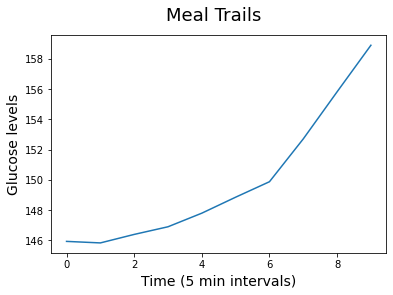

In [9]:
i=3
plt.suptitle('Meal Trails', fontsize='18')
plt.xlabel('Time (5 min intervals)', fontsize ='14')
plt.ylabel('Glucose levels', fontsize='14')
center, avg_dict = get_cluster_center(carb_trails)
plt.plot(center)


No handles with labels found to put in legend.


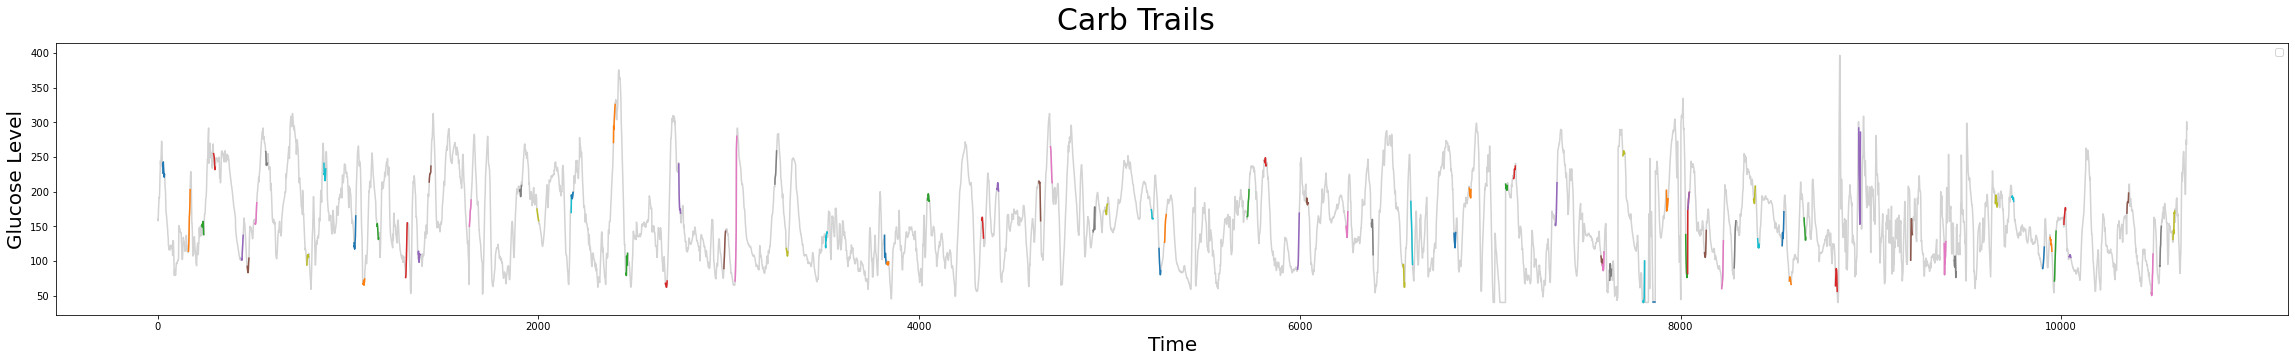

In [10]:
# Since MASS computes z-normalized Euclidean distances, we should z-normalize our subsequences before plotting
plt.figure(figsize=(40,5))
plt.suptitle('Carb Trails', fontsize='30')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('Glucose Level', fontsize='20')
plt.plot(df['Glucose'], color= "lightgray")
for trail in carb_trails:
    plt.plot(trail)
plt.legend()
plt.show()

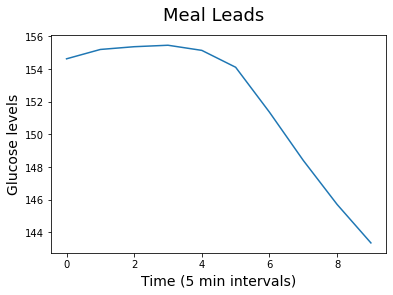

In [11]:
i=3
plt.suptitle('Meal Leads', fontsize='18')
plt.xlabel('Time (5 min intervals)', fontsize ='14')
plt.ylabel('Glucose levels', fontsize='14')
center, avg_dict = get_cluster_center(carb_leads)
plt.plot(center)

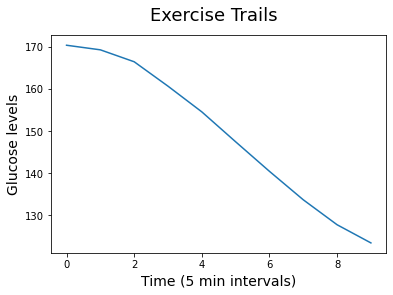

In [12]:
i=3
plt.suptitle('Exercise Trails', fontsize='18')
plt.xlabel('Time (5 min intervals)', fontsize ='14')
plt.ylabel('Glucose levels', fontsize='14')
center, avg_dict = get_cluster_center(exercise_trails)
plt.plot(center)

No handles with labels found to put in legend.


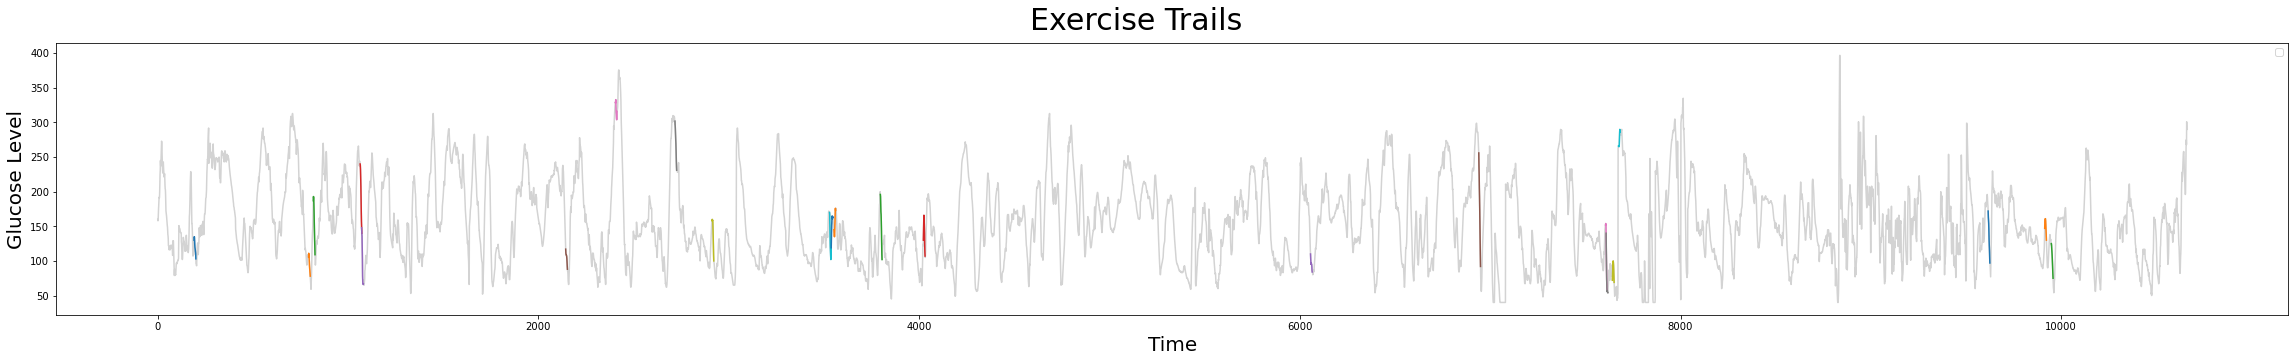

In [13]:
# Since MASS computes z-normalized Euclidean distances, we should z-normalize our subsequences before plotting
plt.figure(figsize=(40,5))
plt.suptitle('Exercise Trails', fontsize='30')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('Glucose Level', fontsize='20')
plt.plot(df['Glucose'], color= "lightgray")
for trail in exercise_trails:
    plt.plot(trail)
plt.legend()
plt.show()

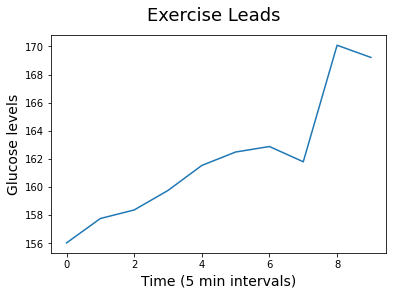

In [14]:
i=3
plt.suptitle('Exercise Leads', fontsize='18')
plt.xlabel('Time (5 min intervals)', fontsize ='14')
plt.ylabel('Glucose levels', fontsize='14')
center, avg_dict = get_cluster_center(exercise_leads)
plt.plot(center)

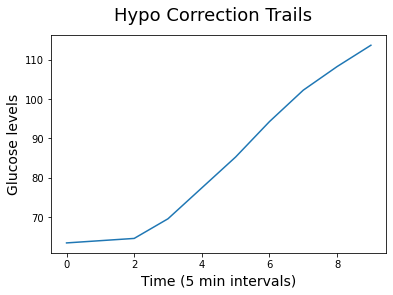

In [15]:
i=3
plt.suptitle('Hypo Correction Trails', fontsize='18')
plt.xlabel('Time (5 min intervals)', fontsize ='14')
plt.ylabel('Glucose levels', fontsize='14')
center, avg_dict = get_cluster_center(hypo_trails)
plt.plot(center)

No handles with labels found to put in legend.


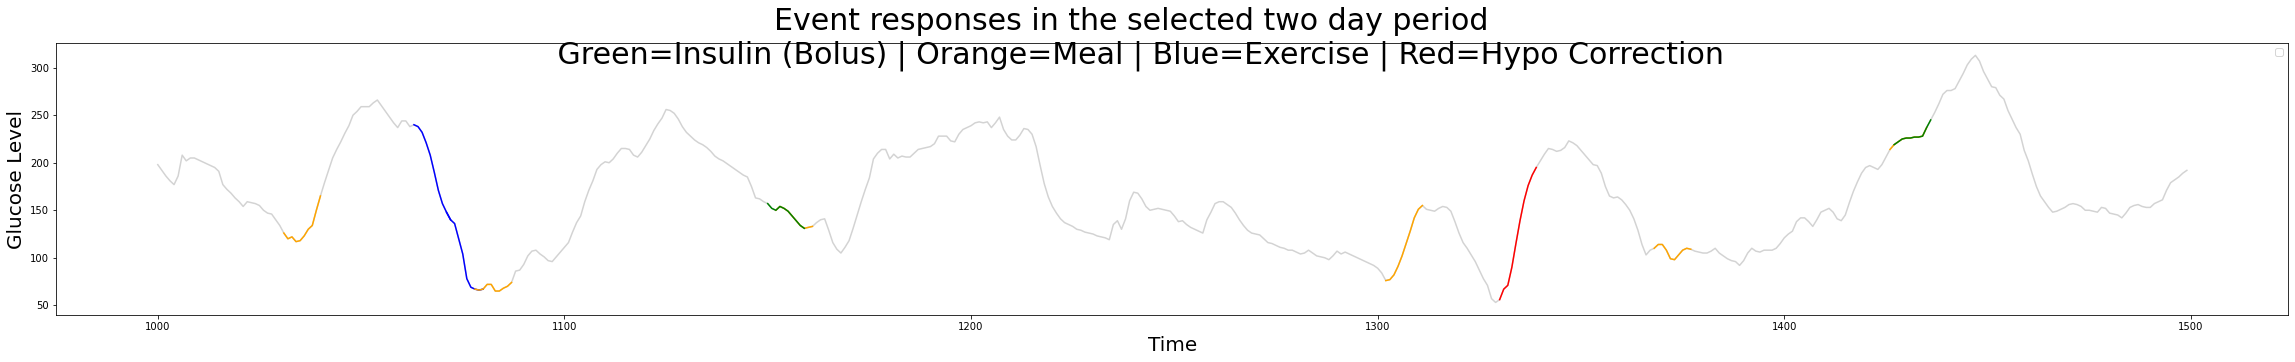

In [16]:
# Since MASS computes z-normalized Euclidean distances, we should z-normalize our subsequences before plotting
plt.figure(figsize=(40,5))
plt.suptitle('Event responses in the selected two day period \n Green=Insulin (Bolus) | Orange=Meal | Blue=Exercise | Red=Hypo Correction', fontsize='30')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('Glucose Level', fontsize='20')
plt.plot(df['Glucose'][1000:1500], color= "lightgray")
for trail in hypo_trails:
    if trail.index[0] > 1000 and trail.index[0] < 1500: plt.plot(trail, color='red')
for trail in exercise_trails:
    if trail.index[0] > 1000 and trail.index[0] < 1500: plt.plot(trail,'blue')
for trail in carb_trails:
    if trail.index[0] > 1000 and trail.index[0] < 1500: plt.plot(trail, 'orange')
for trail in bolus_trails:
    if trail.index[0] > 1000 and trail.index[0] < 1500: plt.plot(trail, 'green')
plt.legend()
plt.show()

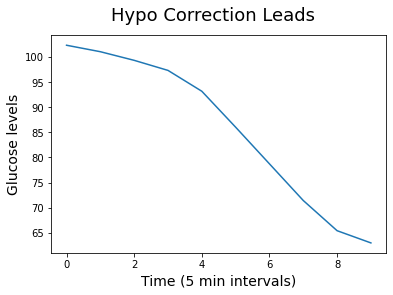

In [17]:
i=3
plt.suptitle('Hypo Correction Leads', fontsize='18')
plt.xlabel('Time (5 min intervals)', fontsize ='14')
plt.ylabel('Glucose levels', fontsize='14')
center, avg_dict = get_cluster_center(hypo_leads)
plt.plot(center)

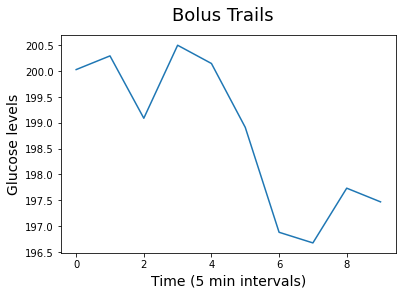

In [18]:
i=3
plt.suptitle('Bolus Trails', fontsize='18')
plt.xlabel('Time (5 min intervals)', fontsize ='14')
plt.ylabel('Glucose levels', fontsize='14')
center, avg_dict = get_cluster_center(bolus_trails)
plt.plot(center)

No handles with labels found to put in legend.


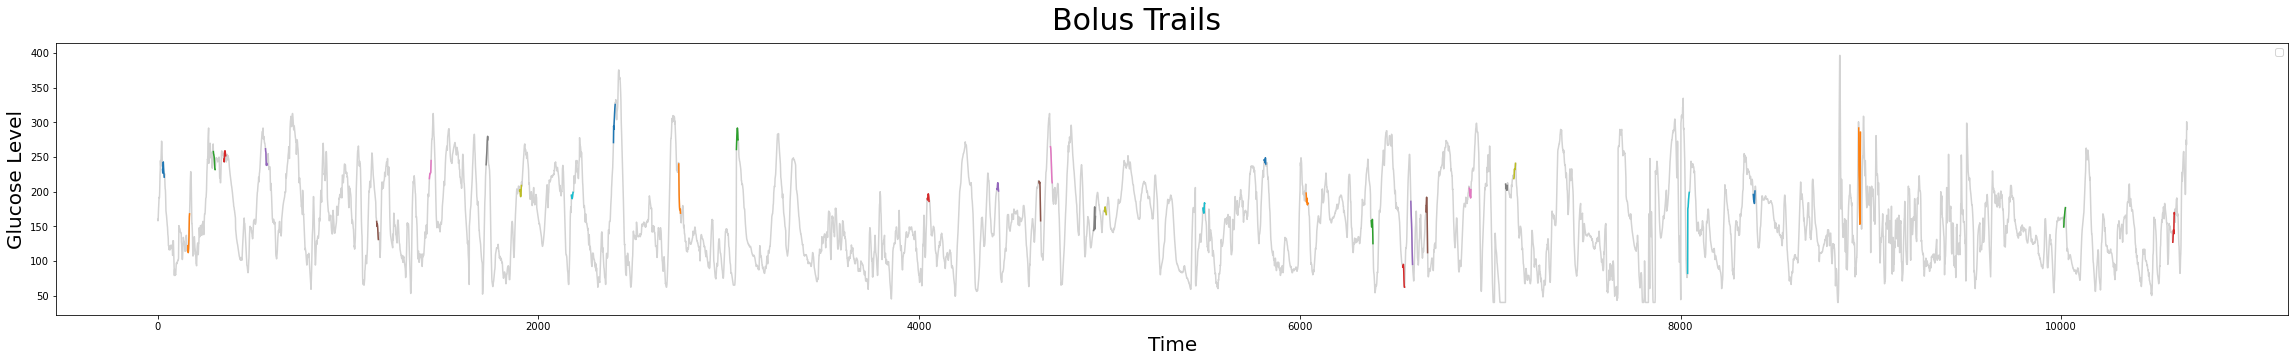

In [19]:
# Since MASS computes z-normalized Euclidean distances, we should z-normalize our subsequences before plotting
plt.figure(figsize=(40,5))
plt.suptitle('Bolus Trails', fontsize='30')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('Glucose Level', fontsize='20')
plt.plot(df['Glucose'], color= "lightgray")
for trail in bolus_trails:
    plt.plot(trail)
plt.legend()
plt.show()

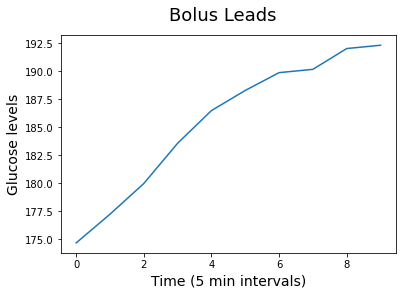

In [20]:
i=3
plt.suptitle('Bolus Leads', fontsize='18')
plt.xlabel('Time (5 min intervals)', fontsize ='14')
plt.ylabel('Glucose levels', fontsize='14')
center, avg_dict = get_cluster_center(bolus_leads)
plt.plot(center)

In [21]:
carb_trails2 = []
for ind, val in enumerate(df['Carbs']):
    if val > 30:
        carb_trails.append(df['Glucose_derivative_alma'][ind:ind+10])

carb_leads2 = []
for ind, val in enumerate(df['Carbs']):
    if val > 30:
        carb_leads.append(df['Glucose_derivative_alma'][ind-10:ind])

bolus_trails2 = []
for ind, val in enumerate(df['Bolus']):
    if val > 5:
        bolus_trails.append(df['Glucose_derivative_alma'][ind:ind+10])

bolus_leads2 = []
for ind, val in enumerate(df['Bolus']):
    if val > 5:
        bolus_leads.append(df['Glucose_derivative_alma'][ind-10:ind])


hypo_trails2 = []
for ind, val in enumerate(df['Hypo_event']):
    if val > 0:
        hypo_trails.append(df['Glucose_derivative_alma'][ind:ind+10])

hypo_leads2 = []
for ind, val in enumerate(df['Hypo_event']):
    if val > 0:
        hypo_leads.append(df['Glucose_derivative_alma'][ind-10:ind])

exercise_trails2 = []
for ind, val in enumerate(df['Exercise']):
    if val > 0:
        exercise_trails.append(df['Glucose_derivative_alma'][ind:ind+10])

exercise_leads2 = []
for ind, val in enumerate(df['Exercise']):
    if val > 0:
        exercise_leads.append(df['Glucose_derivative_alma'][ind-10:ind])

In [23]:
hopkinsum = []
hopkinsum.append(hopkins(np.array(exercise_trails),len(exercise_trails)))
hopkinsum.append(hopkins(np.array(exercise_leads),len(exercise_leads)))
hopkinsum.append(hopkins(np.array(carb_trails),len(carb_trails)))
hopkinsum.append(hopkins(np.array(carb_leads),len(carb_leads)))
hopkinsum.append(hopkins(np.array(bolus_trails),len(bolus_trails)))
hopkinsum.append(hopkins(np.array(bolus_leads),len(bolus_leads)))
hopkinsum.append(hopkins(np.array(hypo_trails),len(hypo_trails)))
hopkinsum.append(hopkins(np.array(hypo_leads),len(hypo_leads)))


In [24]:
hopkins(np.array(hypo_leads),10)

0.13036362615930774

In [25]:
hopkinsum

[0.09421267533179171,
 0.11492290295605818,
 0.06272026991804738,
 0.05614737996984035,
 0.08491928349314656,
 0.08568309641318836,
 0.1838905051430261,
 0.15035868580553044]

In [26]:
sum(hopkinsum)/len(hopkinsum)

0.10410684987882864

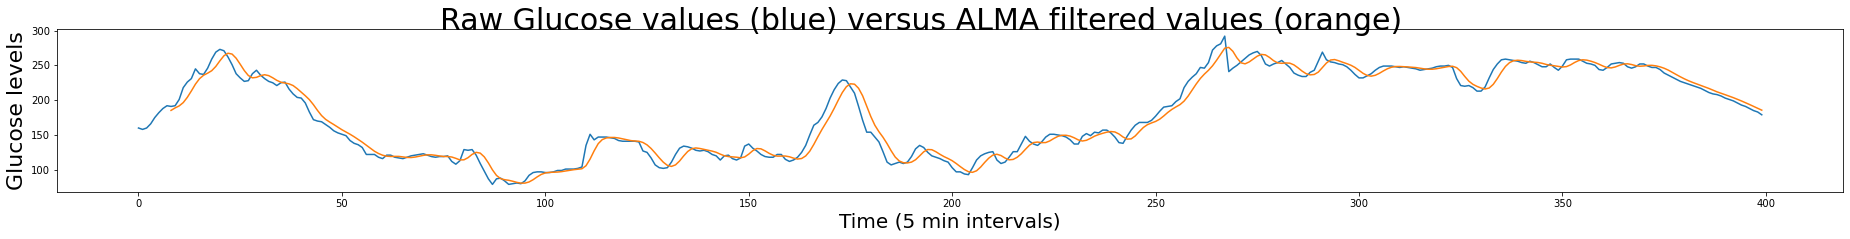

In [27]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [32, 3]  # width, height
plt.rcParams['xtick.direction'] = 'out'
plt.suptitle('Raw Glucose values (blue) versus ALMA filtered values (orange)', fontsize='30')
plt.xlabel('Time (5 min intervals)', fontsize ='20')
plt.ylabel('Glucose levels', fontsize='22')
plt.plot(df['Glucose'][:400])
plt.plot(df['Glucose_alma'][:400])

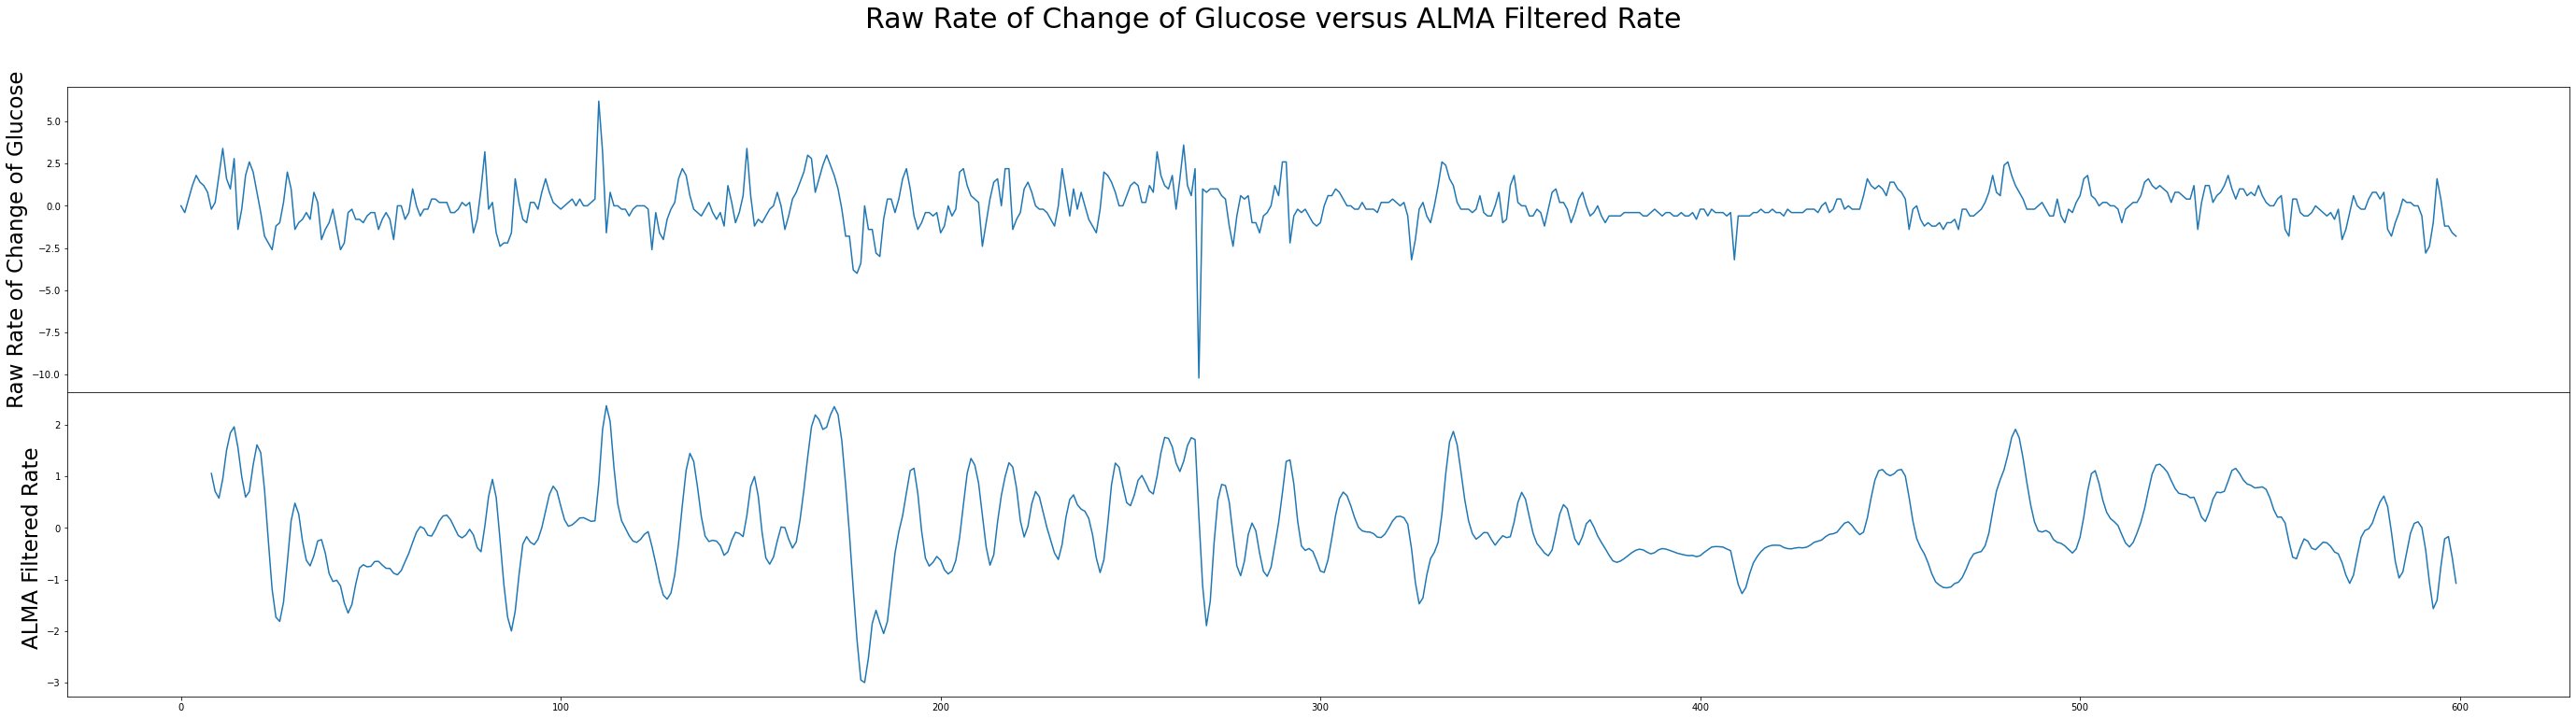

In [28]:
# from matplotlib.pyplot import figure
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Raw Rate of Change of Glucose versus ALMA Filtered Rate ', fontsize='30')
fig.set_size_inches(48, 12)
axs[0].plot(df['Glucose_first_derivative'][:600])
axs[0].set_ylabel('Raw Rate of Change of Glucose', fontsize='23')
axs[1].set_ylabel('ALMA Filtered Rate ', fontsize='23')
axs[1].plot(df['Glucose_derivative_alma'][:600])


In [29]:
# MATRIX PROFILING

# PARAMETERS
motif_length = 10 # motif length, a value of 10 would result in pairing 50 minute intervals
stride_size = 1 # stride size when pairing motifs, how many data points are skipped between each iteration of MP calculation
neighbour_cutoff = 10 # a pattern cannot occur more than once every 80 minutes (16*5 minute interval)
similarity_cutoff = 0.2 # exclude 80% of pairs with highest distance to remove noise

mp = stumpy.stump(df['Glucose'], motif_length, normalize=True, ignore_trivial=True)

In [30]:
mp

array([[0.17859787638994715, 10289, -1, 10289],
       [0.23242117340143725, 3757, -1, 3757],
       [0.3286257046545216, 3758, -1, 3758],
       ...,
       [0.29677890479512914, 2350, 2350, -1],
       [0.396303220569225, 4981, 4981, -1],
       [0.5424409397169865, 3468, 3468, -1]], dtype=object)

In [31]:
from matplotlib.pyplot import figure

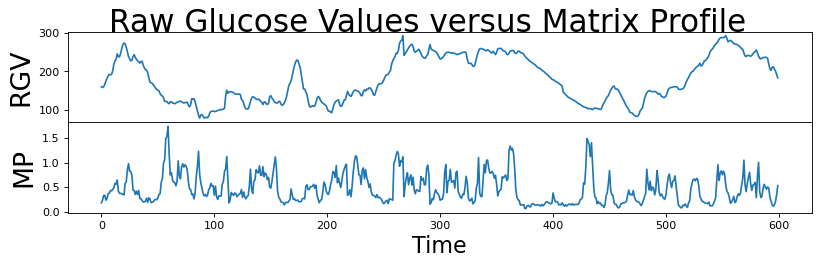

In [32]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(12, 3), dpi=80)
plt.suptitle('Raw Glucose Values versus Matrix Profile', fontsize='28')
axs[0].plot(df['Glucose'][:600])
axs[0].set_ylabel('RGV', fontsize='24')
axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('MP', fontsize='24')
axs[1].plot(mp[:600, 0])



In [33]:
reduced_mp = reduce_mp(mp,similarity_cutoff) 
unique_mp = make_mp_unique(reduced_mp, neighbour_cutoff)
unique_mp[:10]

,Distance,Seq 1 timestamp,Seq 2 timestamp
0,0.000000,7048,7056
24,0.000000,7816,7856
29,0.000009,1747,8159
30,0.000009,5398,10053
33,0.000011,1614,3450
34,0.000011,1995,7741
35,0.000012,5153,7858
38,0.000013,4864,8161
40,0.000017,6458,7814
42,0.000018,3083,5358


In [34]:
reduced_mp[40:80]

,Distance,Seq 1 timestamp,Seq 2 timestamp
40,0.000017,6458,7814
41,0.000017,7050,7854
42,0.000018,3083,5358
43,0.000018,3094,9952
44,0.000021,1992,5360
45,0.000021,3119,7749
46,0.000031,796,3695
47,0.000031,3102,7240
48,0.000034,2477,3696
49,0.000034,3103,5833


c:\Users\metin\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Count of Subsequence Pairs')

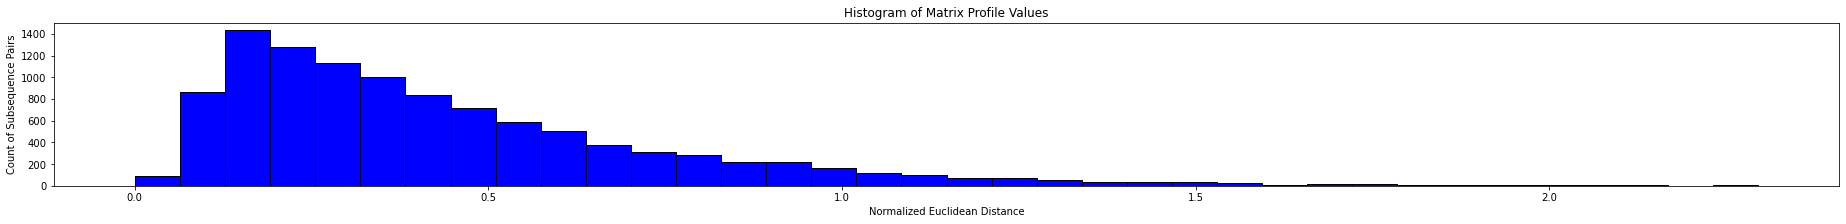

In [35]:
# MP paired minimum distance distribution 
# matplotlib histogram
plt.hist(mp[:, 0], color = 'blue', edgecolor = 'black',
         bins = int(180/5))

# seaborn histogram
sns.distplot(mp[:, 0], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Matrix Profile Values')
plt.xlabel('Normalized Euclidean Distance')
plt.ylabel('Count of Subsequence Pairs')

(array([ 25.,  50.,  75., 100., 125., 150., 175., 200., 225.]),
 <a list of 9 Text major ticklabel objects>)

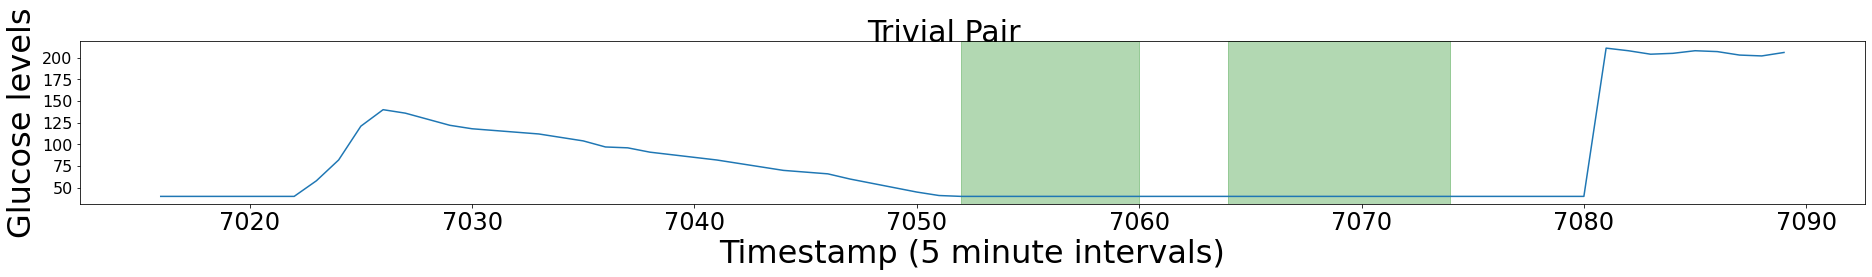

In [36]:
lookback = 32
lookahead = 32
i=0
plt.suptitle('Trivial Pair', fontsize='30')
plt.xlabel('Timestamp (5 minute intervals)', fontsize ='32')
plt.ylabel('Glucose levels', fontsize='32')
plt.plot(df['Glucose'][7048-lookback:7048+motif_length+lookahead])
plt.axvspan(7052, 7050+motif_length, color="green", alpha=0.3)
plt.axvspan(7064, 7064+motif_length, color="green", alpha=0.3)
plt.xticks(size=24)
plt.yticks(size=16)

(array([ 40.,  60.,  80., 100., 120., 140., 160., 180.]),
 <a list of 8 Text major ticklabel objects>)

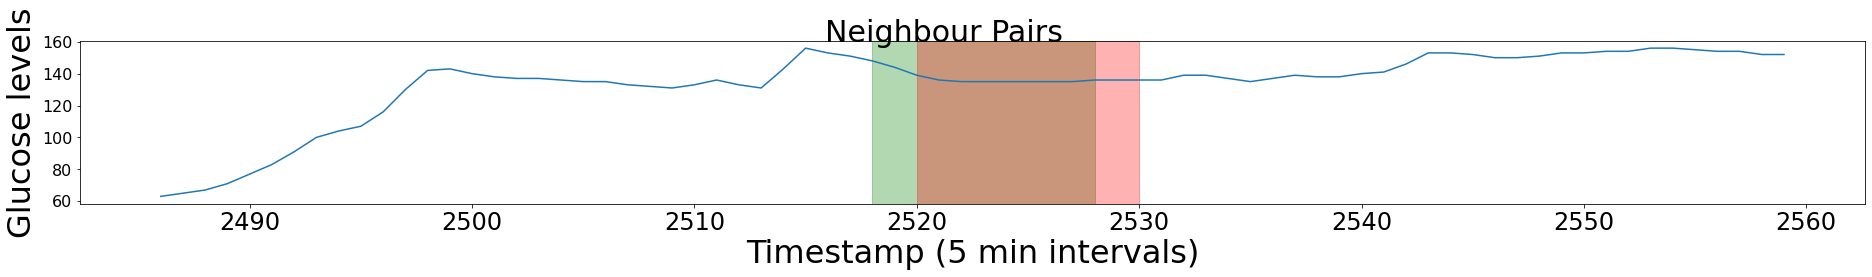

In [37]:
lookback = 32
lookahead = 32
i=0
plt.suptitle('Neighbour Pairs', fontsize='30')
plt.xlabel('Timestamp (5 min intervals)', fontsize ='32')
plt.ylabel('Glucose levels', fontsize='32')
plt.plot(df['Glucose'][2518-lookback:2518+motif_length+lookahead])
plt.axvspan(2518, 2518+motif_length, color="green", alpha=0.3)
plt.axvspan(2520, 2520+motif_length, color="red", alpha=0.3)
plt.xticks(size=24)
plt.yticks(size=16)

(array([  0.,  50., 100., 150., 200., 250., 300.]),
 <a list of 7 Text major ticklabel objects>)

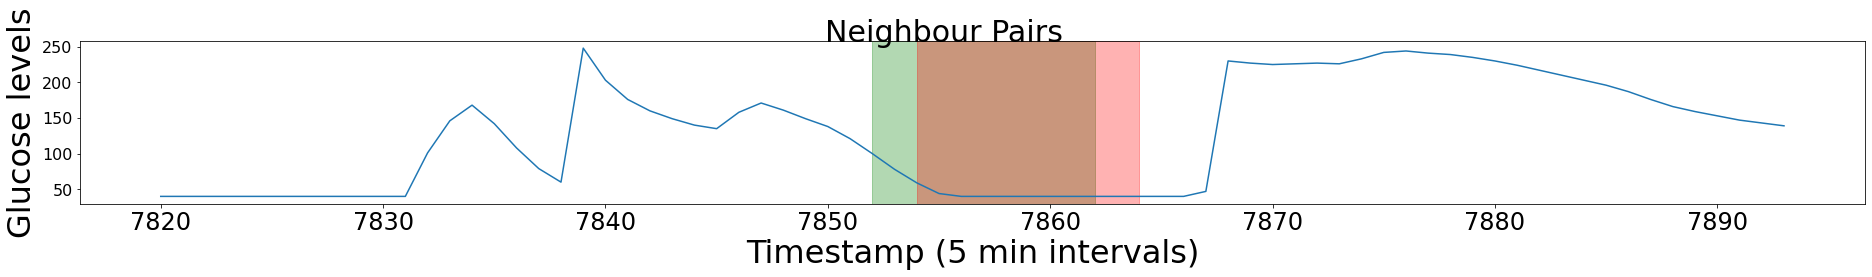

In [38]:
lookback = 32
lookahead = 32
i=0
plt.suptitle('Neighbour Pairs', fontsize='30')
plt.xlabel('Timestamp (5 min intervals)', fontsize ='32')
plt.ylabel('Glucose levels', fontsize='32')
plt.plot(df['Glucose'][7852-lookback:7852+motif_length+lookahead])
plt.axvspan(7852, 7852+motif_length, color="green", alpha=0.3)
plt.axvspan(7854, 7854+motif_length, color="red", alpha=0.3)
plt.xticks(size=24)
plt.yticks(size=16)

In [39]:
ascending, descending, stagnant = cluster_on_gradient(unique_mp, rate_threshold=1)

In [40]:
ascending_motifs = []
for ind in ascending:
        if ind>10 and ind<len(df['Glucose'])-20: ascending_motifs.append(df['Glucose'][ind:ind+10])
descending_motifs = []
for ind in descending:
        descending_motifs.append(df['Glucose'][ind:ind+10])
stagnant_motifs = []
for ind in stagnant:
        stagnant_motifs.append(df['Glucose'][ind:ind+10])

In [41]:
all_motifs=ascending_motifs+descending_motifs+stagnant_motifs

In [42]:
from pyclustertend import assess_tendency_by_mean_metric_score
from sklearn.preprocessing import scale
assess_tendency_by_mean_metric_score(all_motifs,10)


4.333333333333333

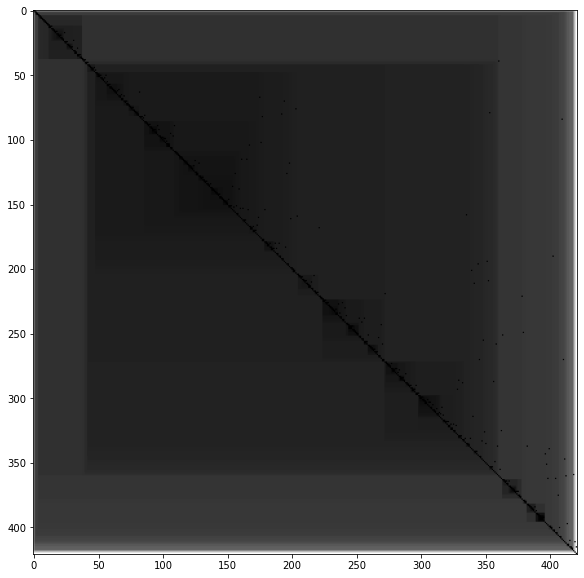

In [43]:
ivat(all_motifs)

In [44]:
hopkinsum = []
hopkinsum.append(hopkins(np.array(ascending_motifs),20))
hopkinsum.append(hopkins(np.array(descending_motifs),20))
hopkinsum.append(hopkins(np.array(stagnant_motifs),10))

In [45]:
hopkinsum

[0.08207181929561216, 0.07416184759787205, 0.19493785033672895]

In [46]:
sum(hopkinsum)/len(hopkinsum)

0.11705717241007106

No handles with labels found to put in legend.


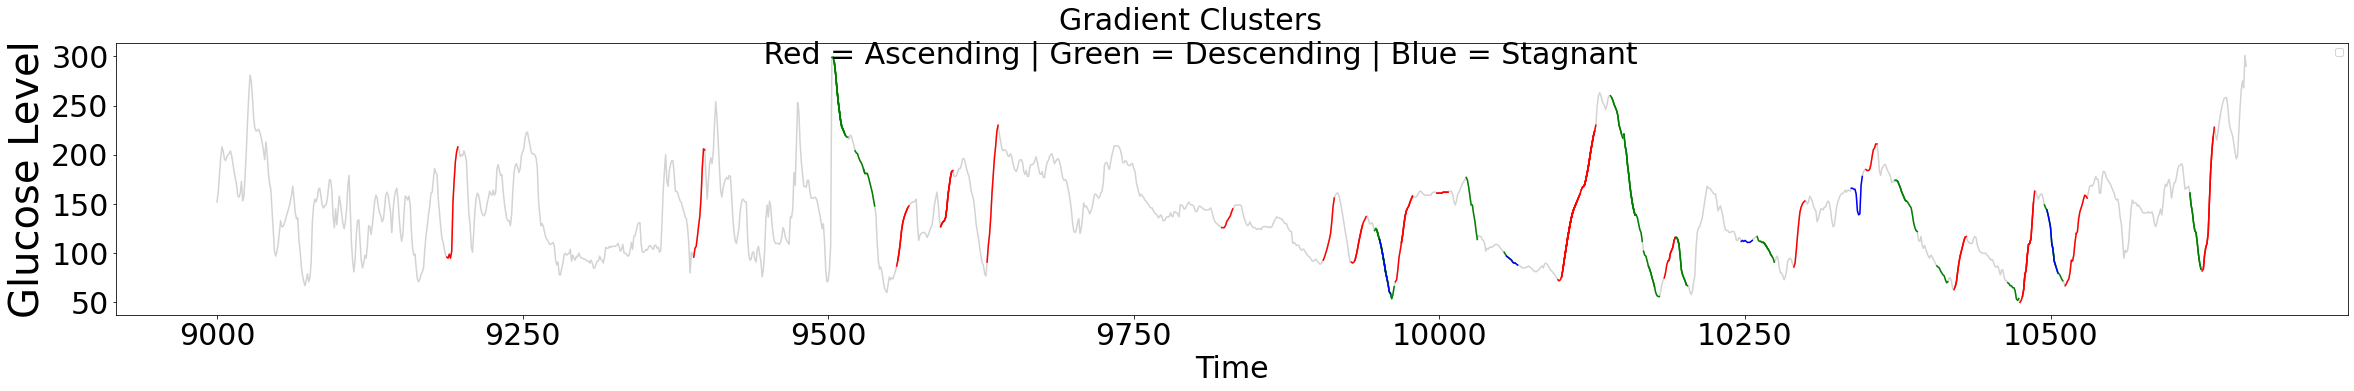

In [47]:
# Since MASS computes z-normalized Euclidean distances, we should z-normalize our subsequences before plotting

plt.figure(figsize=(40,5))
plt.suptitle('Gradient Clusters \n Red = Ascending | Green = Descending | Blue = Stagnant', fontsize='30')
plt.xlabel('Time', fontsize ='30')
plt.ylabel('Glucose Level', fontsize='40')
plt.plot(df['Glucose'][9000:], color= "lightgray")
for idx in ascending:
    if idx > 9000 and idx < 20000: plt.plot(df['Glucose'][idx:idx+motif_length], color='red')
for idx in descending:
    if idx > 9000 and idx < 20000: plt.plot(df['Glucose'][idx:idx+motif_length], color='green')
for idx in stagnant:
    if idx > 9000 and idx < 20000: plt.plot(df['Glucose'][idx:idx+motif_length], color='blue')
plt.xticks(size=30)
plt.yticks(size=30)
plt.legend()
plt.show()


In [48]:
mse_asc = calculate_mse(df, ascending)

In [49]:
mse_desc = calculate_mse(df, descending)

In [50]:
mse_stag = calculate_mse(df, stagnant)

In [51]:
all_dist = [elem[0] for elem in mse_asc.values()]+[elem[0] for elem in mse_desc.values()]+[elem[0] for elem in mse_stag.values()]

In [52]:
min(all_dist)

34800567.567567565

In [53]:
sum(all_dist)/len(all_dist)

8724917460.577696

In [54]:
# # VISUAL

# sleep_indexes = []
# for i in range(len(df)):
#     if df['Sleep'][i] != 0: sleep_indexes.append(i)

# carbs_dict = {}
# for i in range(len(df)):
#     if df['Carbs'][i] > 0: carbs_dict[i] = df['Carbs'][i]
# carbs_dict

# fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
# plt.suptitle('Motif (Pattern) Discovery', fontsize='30')
# axs[0].plot(df['Glucose'])
# axs[0].set_ylabel('Glucose Levels', fontsize='13')
# for idx in range(len(sleep_indexes)): 
#     rect = Rectangle((int(sleep_indexes[idx]), 100), 75, 200, facecolor='lightblue')
#     axs[0].add_patch(rect)
# for key in carbs_dict.keys(): 
#     rect = Rectangle((int(key), 0), 11, carbs_dict[key], facecolor='red')
#     axs[0].add_patch(rect)
# for step in timesteps['Bolus'].keys(): 
#     axs[0].axvline(x=int(step), linestyle="dashed", color='red')
# axs[1].set_xlabel('Time (5 minute intervals)', fontsize ='20')
# axs[1].set_ylabel('Matrix Profile', fontsize='13')
# for motif_idx in ascending: 
#     axs[1].axvline(x=int(motif_idx), linestyle="dashed", color='green')
# axs[1].plot(mp[:, 0])
# print('Blue rectangle: sleep \nRed rectangle: meal \nGreen Lines: pattern start \nRed Lines: hypo event')

In [55]:
# mp[:, 0].max()
# discord_idx = np.argsort(mp[:, 0])[-1]
# nearest_neighbor_distance = mp[discord_idx, 0]
# print(f"The discord is located at index {discord_idx}")

In [56]:
# K MEANS CLUSTERING
kmeans_data = prepare_data_kmeans(unique_mp)
model = TimeSeriesKMeans(n_clusters=4, metric="euclidean", max_iter=10)
model.fit(kmeans_data)
kmeans_labels = model.labels_

In [57]:
cluster_no = 0
c1 = get_cluster_indices(kmeans_data, kmeans_labels, cluster_no)
dist1 = calculate_mse(df, c1)

In [58]:
cluster_no = 1
c2 = get_cluster_indices(kmeans_data, kmeans_labels, cluster_no)
dist2 = calculate_mse(df, c1)

In [59]:
cluster_no = 2
c3 = get_cluster_indices(kmeans_data, kmeans_labels, cluster_no)
dist3 = calculate_mse(df, c1)

In [60]:
cluster_no = 3
c4 = get_cluster_indices(kmeans_data, kmeans_labels, cluster_no)
dist4 = calculate_mse(df, c1)

In [61]:
all_dist = [elem[0] for elem in dist1.values()]+[elem[0] for elem in dist2.values()]+[elem[0] for elem in dist3.values()]+[elem[0] for elem in dist4.values()]

c1_motifs = []
for ind in c1:
        c1_motifs.append(df['Glucose'][ind:ind+10])
c2_motifs = []
for ind in c2:
        c2_motifs.append(df['Glucose'][ind:ind+10])
c3_motifs = []
for ind in c3:
        c3_motifs.append(df['Glucose'][ind:ind+10])
c4_motifs = []
for ind in c4:
        c4_motifs.append(df['Glucose'][ind:ind+10])

In [62]:
random_motifs = []
random_timesteps = []
for iter in range(0,50):
    ind = randint(1,10000)
    random_timesteps.append(ind)
    random_motifs.append(df['Glucose'][ind:ind+10])

In [63]:
rand_dist = calculate_mse(df, random_timesteps)

In [64]:
rand_dist

{'Carbs': [73936800.0],
 'Bolus': [46047888.0],
 'Hypo_event': [28475757105.6],
 'Exercise': [24160571037.6]}

In [65]:
(90041400.0+44276472.0+23957679002.4+15021989484.0)/4

9778496589.6

In [66]:
hopkins(np.array(random_motifs),30)

0.16821345087712652

In [67]:
# MIN AVG DIST TO EVENTS
min(all_dist)

36001294.964028776

In [68]:
# AVG DIST TO EVENTS
sum(all_dist)/len(all_dist)

12172414659.064747

In [69]:
hopkinsum = []
hopkinsum.append(hopkins(np.array(c1_motifs),len(c1_motifs)))
hopkinsum.append(hopkins(np.array(c2_motifs),len(c2_motifs)))
hopkinsum.append(hopkins(np.array(c3_motifs),len(c3_motifs)))
hopkinsum.append(hopkins(np.array(c4_motifs),len(c4_motifs)))

In [70]:
min(hopkinsum)

0.10895236219963052

In [71]:
sum(hopkinsum)/4

0.1275071096775723

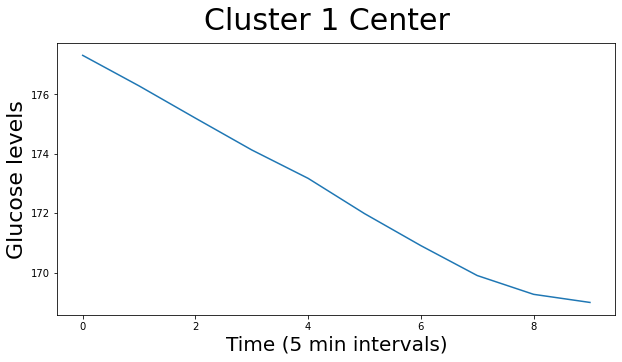

In [72]:
i=0
plt.figure(figsize=(10,5))
plt.suptitle('Cluster 1 Center', fontsize='30')
plt.xlabel('Time (5 min intervals)', fontsize ='20')
plt.ylabel('Glucose levels', fontsize='22')
plt.plot(model.cluster_centers_[i])

No handles with labels found to put in legend.


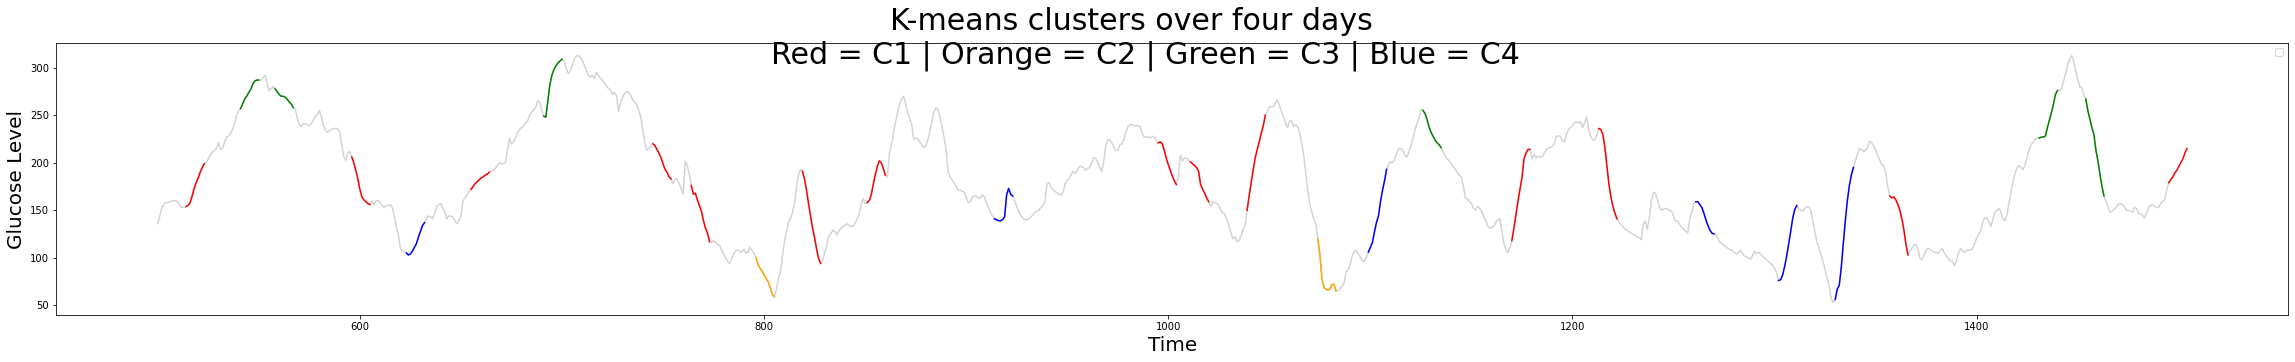

In [73]:
# Since MASS computes z-normalized Euclidean distances, we should z-normalize our subsequences before plotting
plt.figure(figsize=(40,5))
plt.suptitle('K-means clusters over four days \n  Red = C1 | Orange = C2 | Green = C3 | Blue = C4', fontsize='30')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('Glucose Level', fontsize='20')
plt.plot(df['Glucose'][500:1500], color= "lightgray")
for idx in c1:
    if idx < 1500 and idx > 500: plt.plot(df['Glucose'][idx:idx+motif_length], color='red')
for idx in c2:
    if idx < 1500 and idx > 500: plt.plot(df['Glucose'][idx:idx+motif_length], color='orange')
for idx in c3:
    if idx < 1500 and idx > 500: plt.plot(df['Glucose'][idx:idx+motif_length], color='green')
for idx in c4:
    if idx < 1500 and idx > 500: plt.plot(df['Glucose'][idx:idx+motif_length], color='blue')
plt.legend()
plt.show()

In [74]:
# fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
# plt.suptitle('Motif (Pattern) Discovery', fontsize='30')
# axs[0].plot(df['Glucose'])
# axs[0].set_ylabel('Glucose Levels', fontsize='13')
# for idx in range(len(sleep_indexes)): 
#     rect = Rectangle((int(sleep_indexes[idx]), 100), 75, 200, facecolor='lightblue')
#     axs[0].add_patch(rect)
# for key in carbs_dict.keys(): 
#     rect = Rectangle((int(key), 0), 11, carbs_dict[key], facecolor='red')
#     axs[0].add_patch(rect)
# for step in timesteps['Hypo_event'].keys(): 
#     axs[0].axvline(x=int(step), linestyle="dashed", color='red')
# axs[1].set_xlabel('Time (5 minute intervals)', fontsize ='20')
# axs[1].set_ylabel('Matrix Profile', fontsize='13')
# for motif_idx in ascending: 
#     axs[1].axvline(x=int(motif_idx), linestyle="dashed", color='green')
# axs[1].plot(mp[:, 0])
# print('Blue rectangle: sleep \nRed rectangle: meal \nGreen Lines: pattern start \nRed Lines: hypo event')

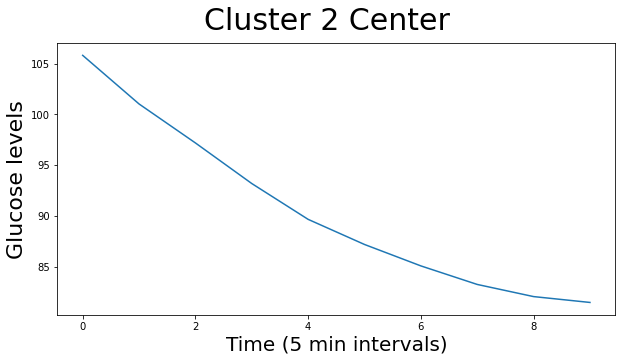

In [75]:
i=1
plt.figure(figsize=(10,5))
plt.suptitle('Cluster 2 Center', fontsize='30')
plt.xlabel('Time (5 min intervals)', fontsize ='20')
plt.ylabel('Glucose levels', fontsize='22')
plt.plot(model.cluster_centers_[i])

In [76]:
for key, val in timesteps['Bolus'].items():
    print(key,val)

0 4.3
10 0.3
25 8.2
42 2.0
77 0.3
158 5.2
215 1.4
233 4.4
265 1.8
292 6.0
311 0.4
348 5.1
409 0.5
439 3.8
470 3.2
544 3.2
566 6.1
595 2.5
727 3.1
759 3.6
782 4.8
864 1.8
871 4.6
895 2.8
1020 0.8
1060 2.4
1079 2.8
1116 1.6
1150 7.1
1168 1.7
1194 2.0
1204 1.0
1302 4.1
1364 4.0
1427 9.3
1442 2.0
1521 3.1
1531 1.0
1595 4.1
1637 0.5
1646 2.5
1671 3.1
1672 1.0
1725 5.9
1846 2.0
1901 6.0
1929 2.1
1967 3.9
1992 3.8
2120 4.4
2169 4.5
2173 5.9
2211 3.4
2214 2.2
2327 2.5
2375 1.8
2394 9.4
2416 2.7
2424 2.5
2458 4.3
2481 2.5
2594 0.3
2609 2.6
2689 3.6
2702 1.2
2737 5.8
2774 1.4
2975 3.7
3040 5.7
3076 1.5
3193 2.4
3196 1.8
3242 4.5
3258 1.2
3300 0.1
3302 3.8
3333 3.0
3350 1.5
3465 1.9
3508 2.1
3584 2.9
3621 2.2
3753 2.3
3818 3.7
3819 2.2
3830 3.3
3872 3.3
3977 0.5
4043 7.6
4091 2.0
4113 2.4
4151 1.3
4165 2.8
4241 4.1
4273 4.4
4327 4.6
4359 3.0
4408 8.8
4461 0.7
4546 1.2
4565 1.6
4588 2.8
4629 8.5
4678 3.2
4689 0.7
4690 5.2
4733 2.9
4787 3.2
4850 3.8
4917 5.6
4974 5.3
4986 1.5
5019 0.5
5159 3.2
5221

No handles with labels found to put in legend.


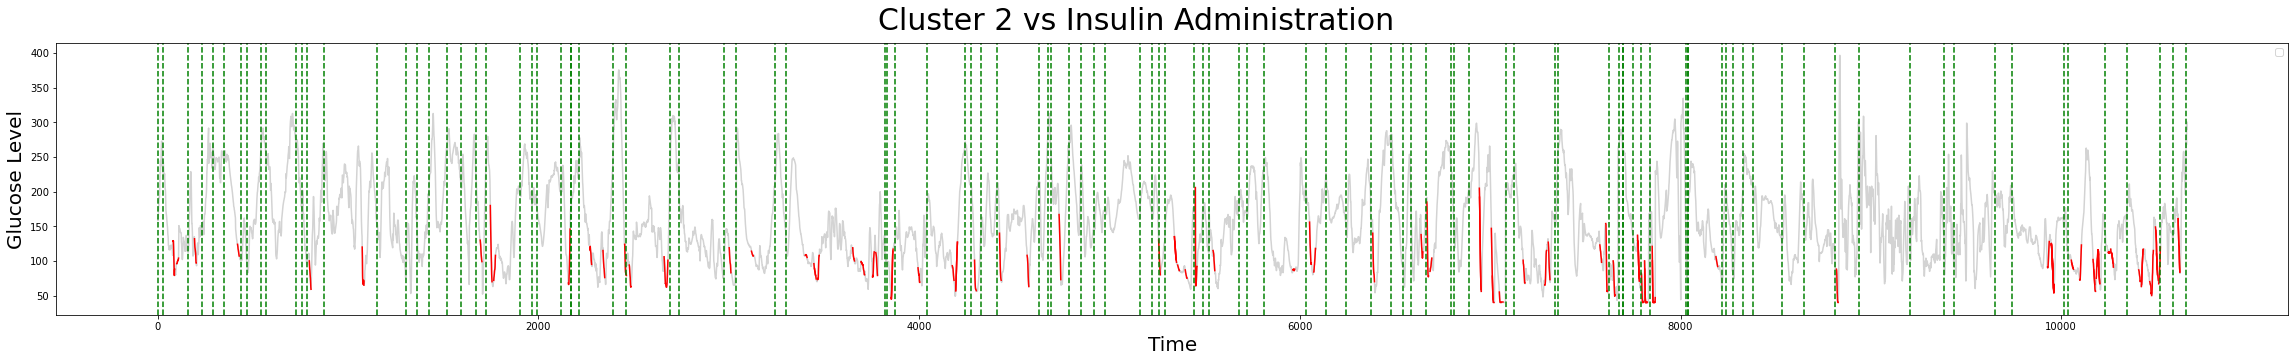

In [77]:
# Since MASS computes z-normalized Euclidean distances, we should z-normalize our subsequences before plotting
plt.figure(figsize=(40,5))
plt.suptitle('Cluster 2 vs Insulin Administration', fontsize='30')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('Glucose Level', fontsize='20')
plt.plot(df['Glucose'], color= "lightgray")
for idx in c2:
    plt.plot(df['Glucose'][idx:idx+motif_length], color='red')
for ind, val in timesteps['Bolus'].items(): 
    if val > 3: plt.axvline(x=int(ind), linestyle="dashed", color='green')
plt.legend()
plt.show()

No handles with labels found to put in legend.


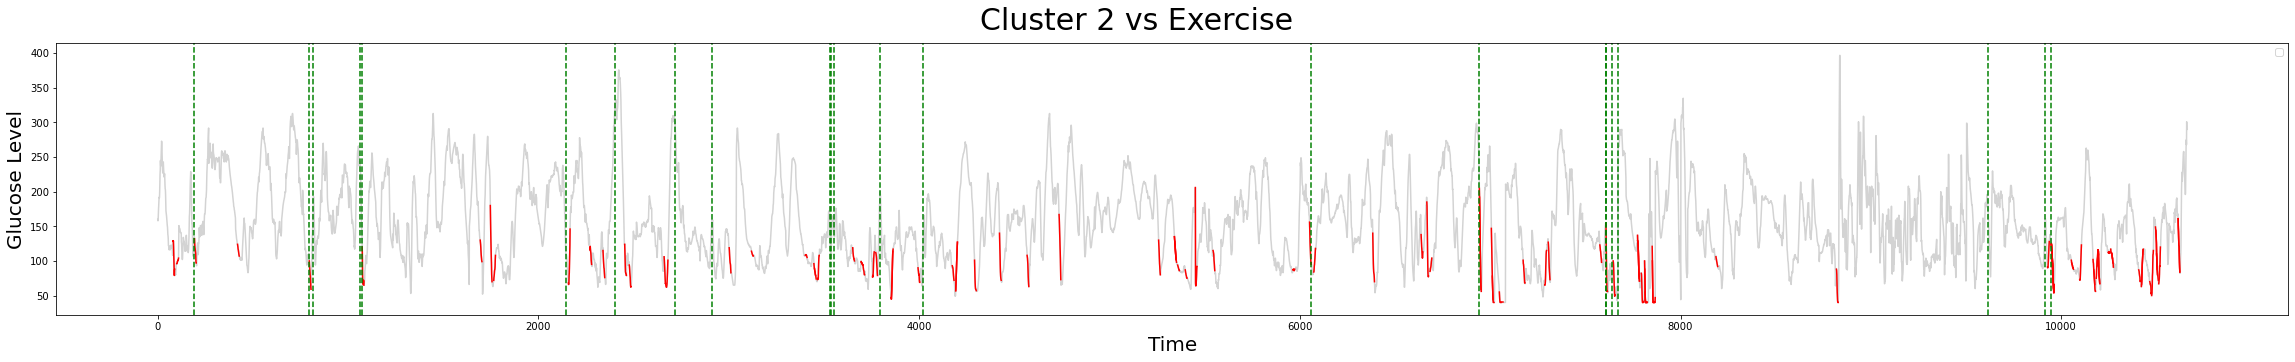

In [78]:
# Since MASS computes z-normalized Euclidean distances, we should z-normalize our subsequences before plotting
plt.figure(figsize=(40,5))
plt.suptitle('Cluster 2 vs Exercise', fontsize='30')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('Glucose Level', fontsize='20')
plt.plot(df['Glucose'], color= "lightgray")
for idx in c2:
    plt.plot(df['Glucose'][idx:idx+motif_length], color='red')
for ind, val in timesteps['Exercise'].items(): 
    if val > 0: plt.axvline(x=int(ind), linestyle="dashed", color='green')
plt.legend()
plt.show()

No handles with labels found to put in legend.


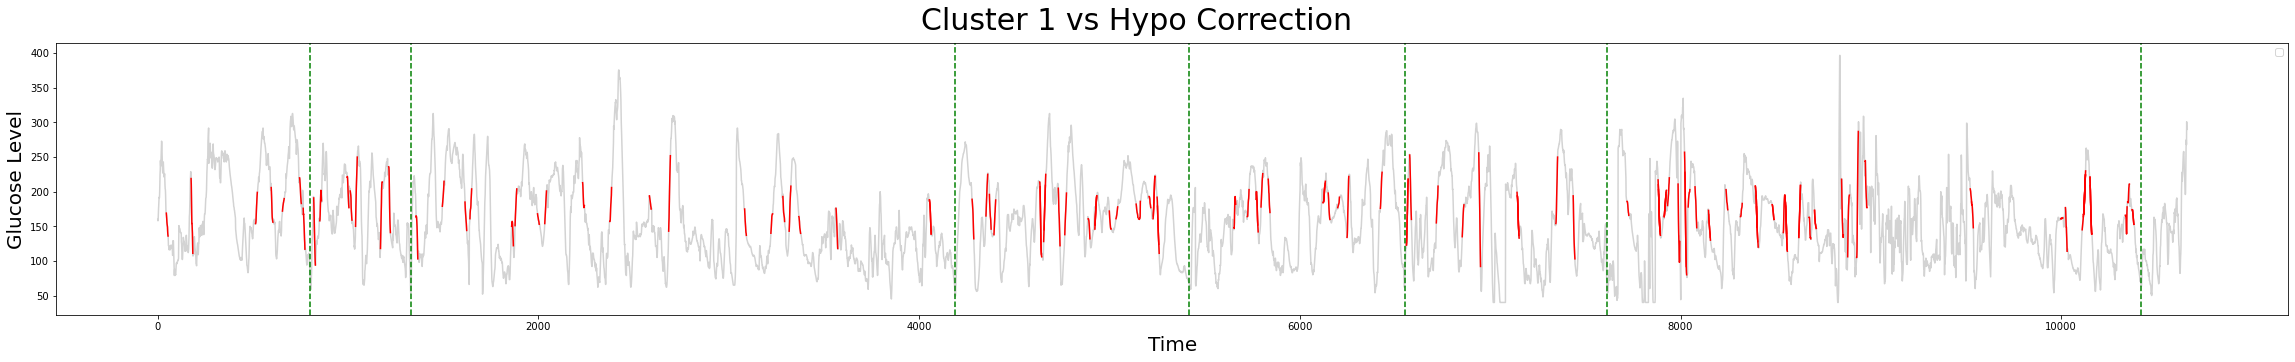

In [79]:
# Since MASS computes z-normalized Euclidean distances, we should z-normalize our subsequences before plotting
plt.figure(figsize=(40,5))
plt.suptitle('Cluster 1 vs Hypo Correction', fontsize='30')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('Glucose Level', fontsize='20')
plt.plot(df['Glucose'], color= "lightgray")
for idx in c1:
    plt.plot(df['Glucose'][idx:idx+motif_length], color='red')
for ind, val in timesteps['Hypo_event'].items(): 
    if val > 0: plt.axvline(x=int(ind), linestyle="dashed", color='green')
plt.legend()
plt.show()

No handles with labels found to put in legend.


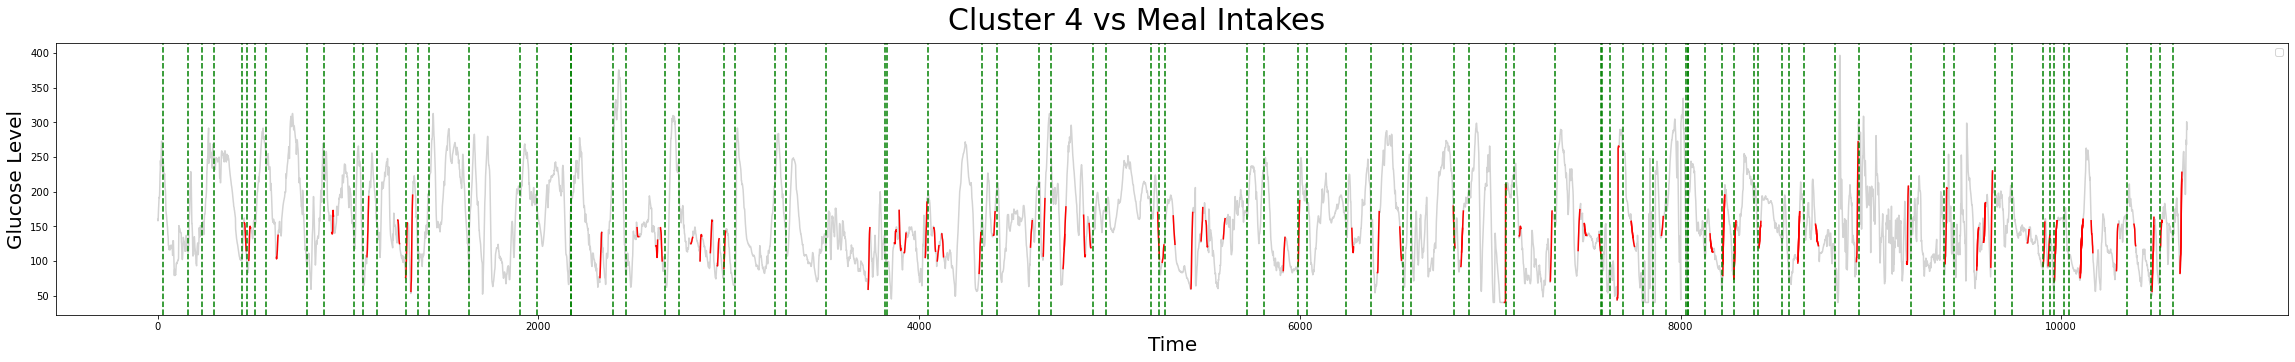

In [80]:
# Since MASS computes z-normalized Euclidean distances, we should z-normalize our subsequences before plotting
plt.figure(figsize=(40,5))
plt.suptitle('Cluster 4 vs Meal Intakes', fontsize='30')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('Glucose Level', fontsize='20')
plt.plot(df['Glucose'], color= "lightgray")
for idx in c4:
    plt.plot(df['Glucose'][idx:idx+motif_length], color='red')
for ind, val in timesteps['Carbs'].items(): 
    if val > 30: plt.axvline(x=int(ind), linestyle="dashed", color='green')
plt.legend()
plt.show()

No handles with labels found to put in legend.


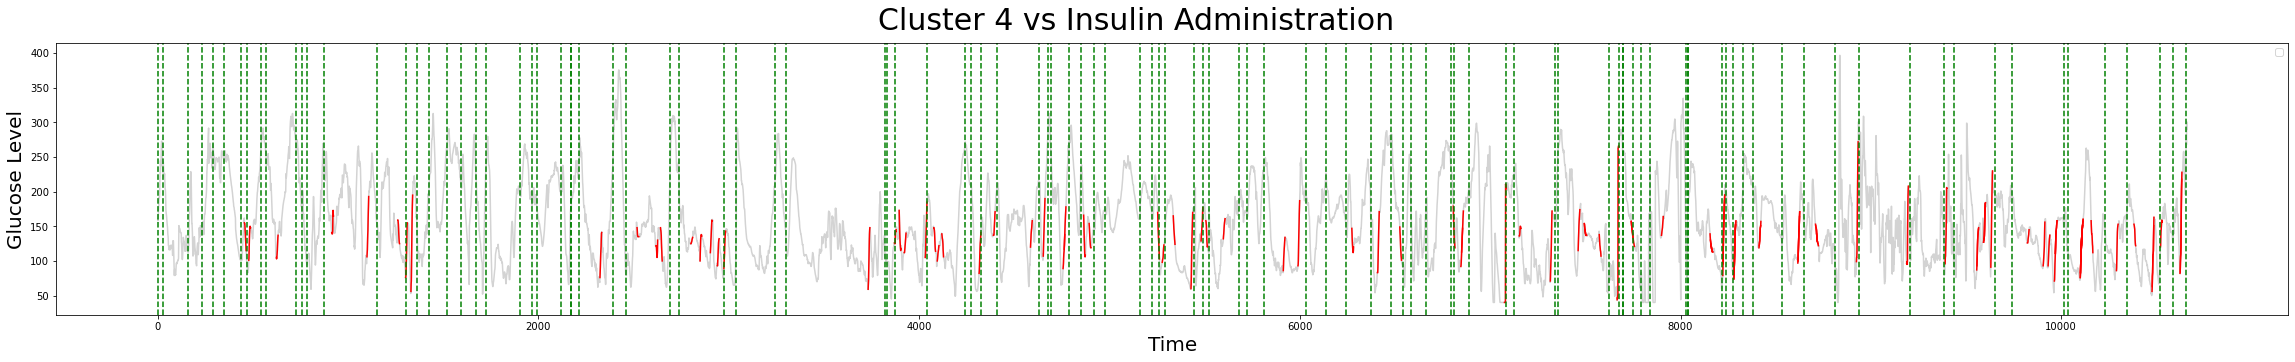

In [81]:
# Since MASS computes z-normalized Euclidean distances, we should z-normalize our subsequences before plotting
plt.figure(figsize=(40,5))
plt.suptitle('Cluster 4 vs Insulin Administration', fontsize='30')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('Glucose Level', fontsize='20')
plt.plot(df['Glucose'], color= "lightgray")
for idx in c4:
    plt.plot(df['Glucose'][idx:idx+motif_length], color='red')
for ind, val in timesteps['Bolus'].items(): 
    if val > 3: plt.axvline(x=int(ind), linestyle="dashed", color='green')
plt.legend()
plt.show()

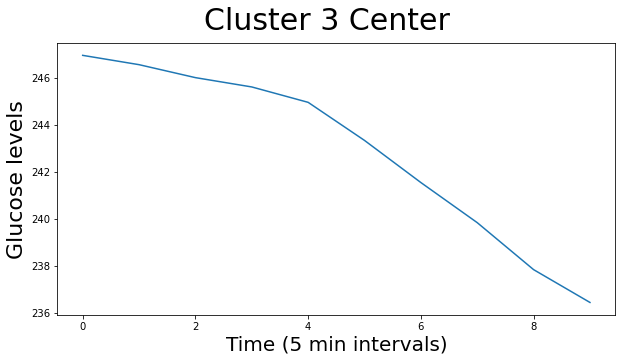

In [82]:
i=2
plt.figure(figsize=(10,5))
plt.suptitle('Cluster 3 Center', fontsize='30')
plt.xlabel('Time (5 min intervals)', fontsize ='20')
plt.ylabel('Glucose levels', fontsize='22')
plt.plot(model.cluster_centers_[i])

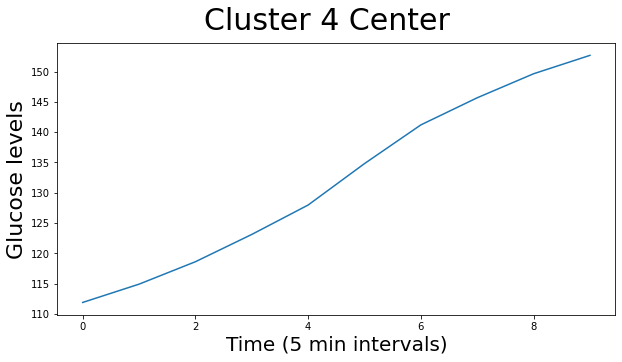

In [83]:
i=3
plt.figure(figsize=(10,5))
plt.suptitle('Cluster 4 Center', fontsize='30')
plt.xlabel('Time (5 min intervals)', fontsize ='20')
plt.ylabel('Glucose levels', fontsize='22')
plt.plot(model.cluster_centers_[i])

No handles with labels found to put in legend.


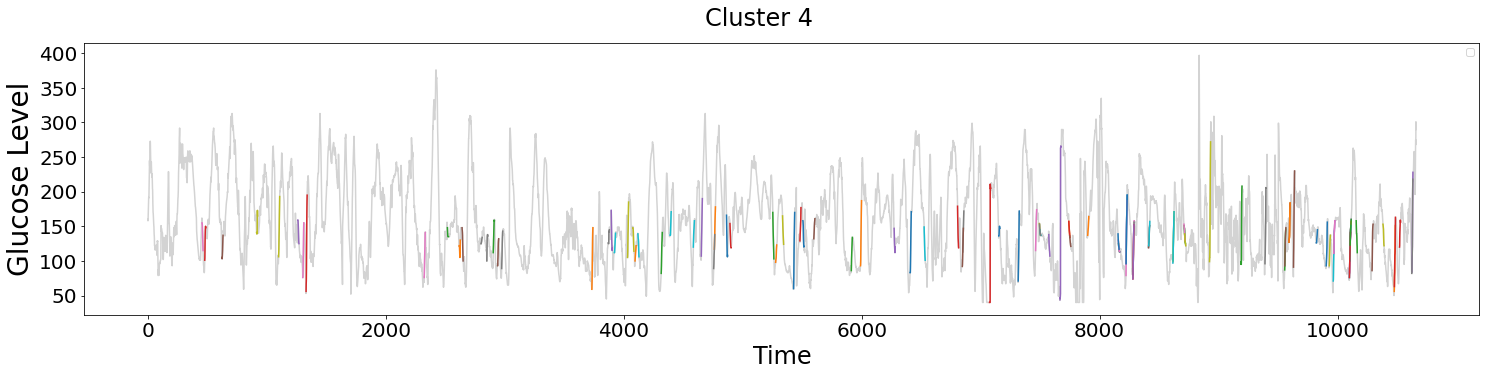

In [84]:
# Since MASS computes z-normalized Euclidean distances, we should z-normalize our subsequences before plotting
plt.figure(figsize=(25,5))
plt.suptitle('Cluster 4', fontsize='24')
plt.xlabel('Time', fontsize ='24')
plt.ylabel('Glucose Level', fontsize='28')
plt.plot(df['Glucose'], color= "lightgray")
for idx in c4:
    plt.plot(df['Glucose'][idx:idx+motif_length])
plt.legend()
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

No handles with labels found to put in legend.


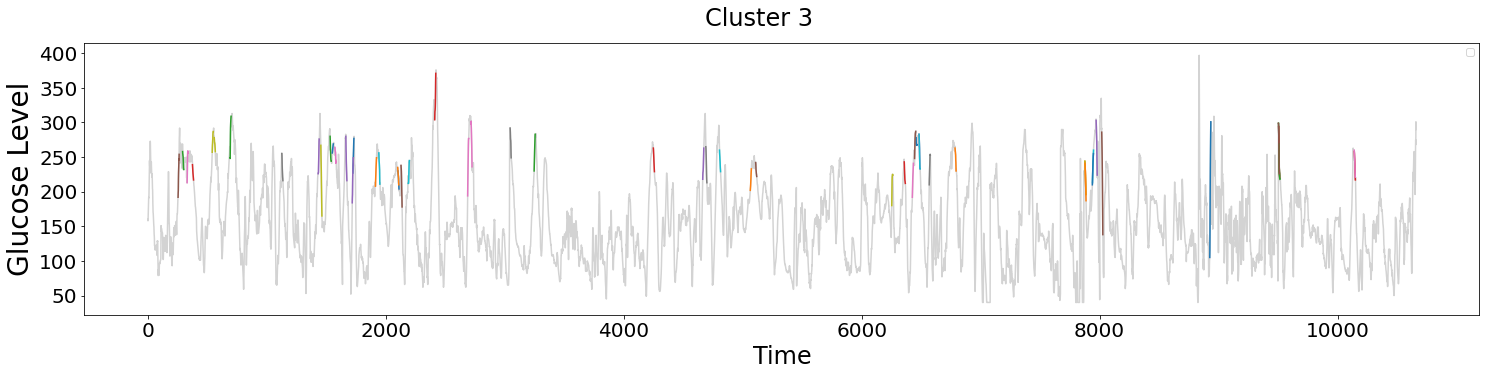

In [85]:
# Since MASS computes z-normalized Euclidean distances, we should z-normalize our subsequences before plotting
plt.figure(figsize=(25,5))
plt.suptitle('Cluster 3', fontsize='24')
plt.xlabel('Time', fontsize ='24')
plt.ylabel('Glucose Level', fontsize='28')
plt.plot(df['Glucose'], color= "lightgray")
for idx in c3:
    plt.plot(df['Glucose'][idx:idx+motif_length])
plt.legend()
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

No handles with labels found to put in legend.


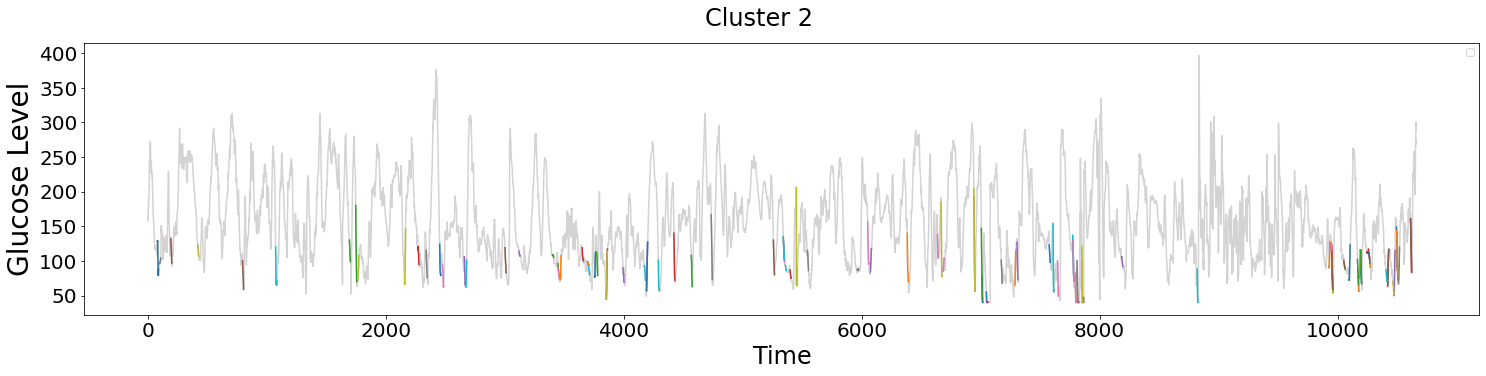

In [86]:
# Since MASS computes z-normalized Euclidean distances, we should z-normalize our subsequences before plotting
plt.figure(figsize=(25,5))
plt.suptitle('Cluster 2', fontsize='24')
plt.xlabel('Time', fontsize ='24')
plt.ylabel('Glucose Level', fontsize='28')
plt.plot(df['Glucose'], color= "lightgray")
for idx in c2:
    plt.plot(df['Glucose'][idx:idx+motif_length])
plt.legend()
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

No handles with labels found to put in legend.


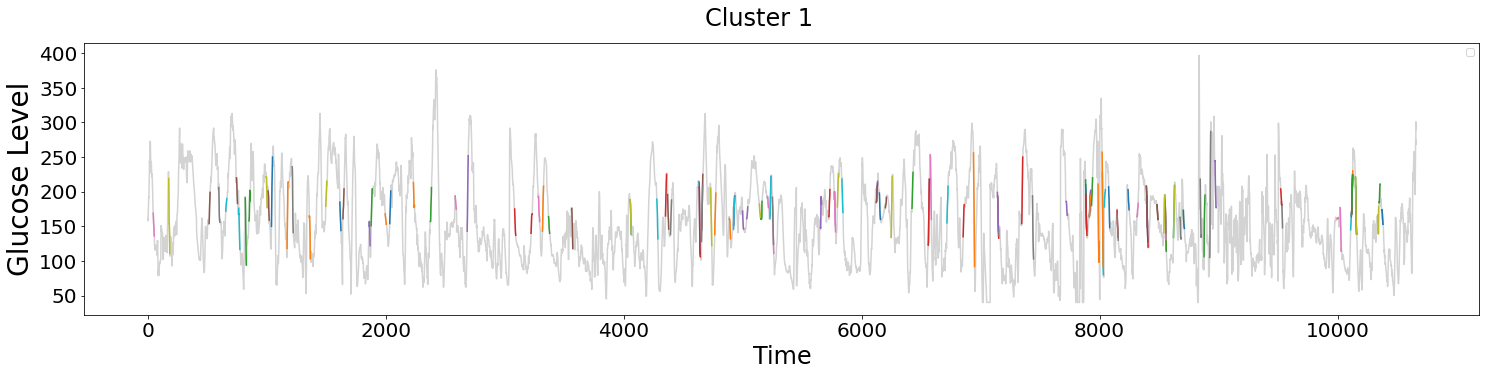

In [87]:
# Since MASS computes z-normalized Euclidean distances, we should z-normalize our subsequences before plotting
plt.figure(figsize=(25,5))
plt.suptitle('Cluster 1', fontsize='24')
plt.xlabel('Time', fontsize ='24')
plt.ylabel('Glucose Level', fontsize='28')
plt.plot(df['Glucose'], color= "lightgray")
for idx in c1:
    plt.plot(df['Glucose'][idx:idx+motif_length])
plt.legend()
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [95]:
avg_dict = get_cluster_values(c1)

TypeError: object of type 'int' has no len()

Text(0, 0.5, 'Count of Subsequence Pairs')

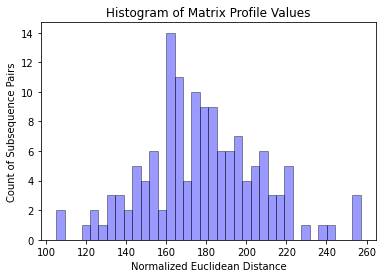

In [111]:
sns.distplot(avg_dict[0], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Matrix Profile Values')
plt.xlabel('Normalized Euclidean Distance')
plt.ylabel('Count of Subsequence Pairs')

In [88]:
fcm = FCM(n_clusters=8)
unique_indexes = list()
for elem in unique_mp['Seq 1 timestamp']: unique_indexes.append(elem)
for elem in unique_mp['Seq 2 timestamp']: unique_indexes.append(elem)
X = np.array([df['Glucose'][idx:idx+motif_length] for idx in unique_indexes])
fcm.fit(X)

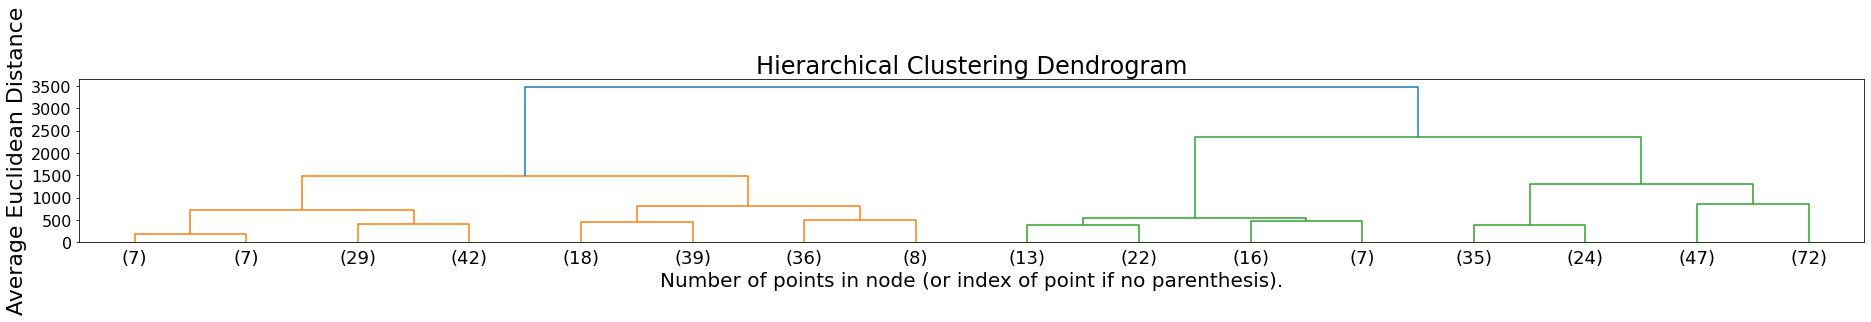

In [89]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram", size=24)
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).", size=20)
plt.ylabel("Average Euclidean Distance", size=22)
plt.xticks(size=18)
plt.yticks(size=16)
plt.show()

In [90]:
# # HANDMADE ALGORITHM MATRIX

# window_size = 24
# stride_size = 32
# dtw_matrix = dict.fromkeys([i for i in range(len(df['Glucose'])) if i%stride_size == 0 and i < len(df['Glucose'])- window_size])

# for i in dtw_matrix.keys():
#     sub_dict = dict.fromkeys([i for i in range(len(df['Glucose'])) if i%stride_size == 0 and i < len(df['Glucose'])- window_size])
#     for j in dtw_matrix.keys():
#         distance, path = fastdtw(df['Glucose'][i:i+window_size], df['Glucose'][j:j+window_size], dist=euclidean)
#         sub_dict[j] = distance
#     dtw_matrix[i] = sub_dict

# print(distance)
# print(path)



# # with open('dtw_matrix.json', 'wb') as fp:
# #     pickle.dump(dtw_matrix, fp)

In [91]:
# dtw_matrix

In [92]:
%matplotlib inline

import pandas as pd
import numpy as np
import stumpy
from stumpy.floss import _cac
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch
from matplotlib import animation
from IPython.display import HTML
import os

In [93]:
L = 210
cac, regime_locations = stumpy.fluss(mp[:, 1], L=L, n_regimes=2, excl_factor=1)

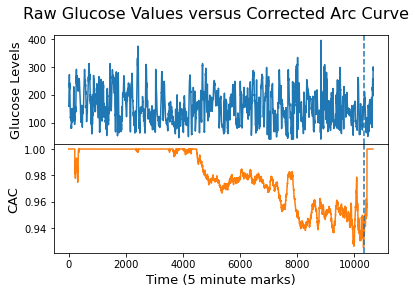

In [94]:
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Raw Glucose Values versus Corrected Arc Curve', fontsize='16')
axs[0].plot(range(df['Glucose'].shape[0]), df['Glucose'])
axs[0].axvline(x=regime_locations[0], linestyle="dashed")
axs[0].set_ylabel('Glucose Levels', fontsize='13')
axs[1].plot(range(cac.shape[0]), cac, color='C1')
axs[1].axvline(x=regime_locations[0], linestyle="dashed")
axs[1].set_ylabel('CAC', fontsize='13')
axs[1].set_xlabel('Time (5 minute marks)', fontsize='13')
plt.show()